#7. FEATURE ENGINEERING

##7.01 Initial work.

In [0]:
#Importing basic libraries:
import pandas as pd
import numpy as np
import timeit
import ujson
import os

In [0]:
#Click on the link, copy the authorization code and paste it on the box.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Now we have access to our own Google Drive account:
!ls -lh "/content/drive/My Drive/"

total 3.2G
drwx------ 2 root root 4.0K Jul 14 07:08  20180714_Deep_Learning
-rw------- 1 root root  76K Oct 22 18:13  6885.json
drwx------ 2 root root 4.0K Jun 26  2016 'avast! Files (XT1068, UWbYzWPVmAmwlrlD)'
-rw------- 1 root root 2.4M Nov 18 17:06  Cast_Crew_ids.csv
drwx------ 2 root root 4.0K Jul 18 18:38 'Colab Notebooks'
-rw------- 1 root root  44K Feb  4  2018  contacts.vcf
-rw------- 1 root root    1 Apr  9  2018  facturaIVA.gsheet
-rw------- 1 root root  50K Nov 19 18:53  genres.xlsx
-rw------- 1 root root 1.5M Oct 24 17:34  IMDB_5000_movie.csv
-rw------- 1 root root  12K Nov  3 10:33  InflationConverter.xlsx
-rw------- 1 root root    1 Nov 10 10:21 'Mis cuentas.gsheet'
-rw------- 1 root root  93K Nov 18 17:05  Movies_ids.csv
-rw------- 1 root root 2.2M Nov 16 17:17  MoviesUS.csv
-rw------- 1 root root 1.5G Oct 12 15:09  movies.zip
-rw------- 1 root root    1 Nov 17 16:27 'Nuestras Cuentas.gsheet'
-rw------- 1 root root 1.8G Oct 27 13:06  people.zip
-rw------- 1 root root 6.4

In [0]:
# Install the PyDrive wrapper & import libraries. This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Getting files from my Google Drive account:

#movies data
file_id = '1-jrX_p1VfgMceGIj7SK_eIef8syIGsdL'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("movies.zip")

#movies ids
file_id = '1-1M-smshevfKWEj5DPpxHJ6QzP82m2c7'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("Movies_ids.csv")

#people data
file_id = '1UnpPTqVcghfQzj55RIoLm8pBH_Rjdl4f'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("people.zip")

#people ids
file_id = '19oOa9qjMFnDv19DHmNTTJKIuGW8X5BkQ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("Cast_Crew_ids.csv")

#IMDB 5000 movies:
file_id = '1ebj6EkGylXTGldfGfJO_AHEAncNf4zKA'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("IMDB_5000_movie.csv")

#$US inflation converter:
file_id = '11Xut6okhEWdNhsOgokYtFUvNEBfYwlWx'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("InflationConverter.xlsx")

In [0]:
!ls -lh

total 3.2G
-rw-r--r-- 1 root root 2.5K Nov 19 20:06 adc.json
-rw-r--r-- 1 root root 2.4M Nov 19 20:07 Cast_Crew_ids.csv
drwx------ 3 root root 4.0K Nov 19 20:04 drive
-rw-r--r-- 1 root root 1.5M Nov 19 20:07 IMDB_5000_movie.csv
-rw-r--r-- 1 root root  12K Nov 19 20:07 InflationConverter.xlsx
-rw-r--r-- 1 root root  93K Nov 19 20:07 Movies_ids.csv
-rw-r--r-- 1 root root 1.5G Nov 19 20:07 movies.zip
-rw-r--r-- 1 root root 1.8G Nov 19 20:07 people.zip
drwxr-xr-x 2 root root 4.0K Nov 16 17:41 sample_data


In [0]:
#We will need this to import xlsx files:
!pip install xlrd

    100% |████████████████████████████████| 112kB 3.1MB/s 


In [0]:
#We will get an error message. No worries about it!
!mkdir themoviedb_data
!cd themoviedb_data && unzip -q ../movies.zip
!cd themoviedb_data && unzip -q ../people.zip
!ls -lh themoviedb_data

warning [../movies.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [../movies.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #409792).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)
warning [../people.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [../people.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #1197557).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)
total 45M
drwxr-xr-x 2 root root 12M Nov 

In [0]:
!ls -1 themoviedb_data/movies | wc -l

409791


In [0]:
!ls -1 themoviedb_data/people | wc -l

1197556


##7.02 Creating my movies dataframe.

We execute the script we already know from last notebooks:

In [0]:
#Reading file and saving in df
dfMoviesIds = pd.read_csv('./Movies_ids.csv')
setMoviesIds = set(dfMoviesIds['movie_id'])

In [0]:
def moviesIterator(path):
    intI = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            intI += 1
            if f.endswith('.json'):
                fp = os.path.join(root,f)
                with open(fp) as o:
                    data = ujson.load(o)
                
                if intI % 10000 == 0:
                    print(intI)
                    
                result = {"titles": data["alternative_titles"]["titles"], 
                       "budget": data["budget"], "credits_cast": data["credits"]["cast"], "credits_crew": data["credits"]["crew"],
                       "genres": data["genres"], "movie_id": data["id"], "imdb_id": data["imdb_id"],
                       "keywords": data["keywords"]["keywords"], "original_language": data["original_language"],
                       "original_title": data["original_title"], "overview": data["overview"],
                       "popularity": data["popularity"], 
                       "production_companies": data["production_companies"], "production_countries": data["production_countries"],
                       "release_date": data["release_date"], "release_dates": data["release_dates"]["results"],
                       "revenue": data["revenue"], 
                       "reviews_page": data["reviews"]["page"],
                       "reviews_results": data["reviews"]["results"],
                       "reviews_total_pages": data["reviews"]["total_pages"],
                       "reviews_total_results": data["reviews"]["total_results"],
                       "runtime": data["runtime"],
                       "spoken_languages": data["spoken_languages"], "status": data["status"],
                       "tagline": data["tagline"], "title": data["title"], 
                       "vote_average": data["vote_average"], "vote_count": data["vote_count"]}
                    
                if data["belongs_to_collection"] is None:
                    result["belongs_to_collection_id"] = None
                    result["belongs_to_collection_name"] = None
                else:
                    result["belongs_to_collection_id"] = data["belongs_to_collection"]["id"]
                    result["belongs_to_collection_name"] = data["belongs_to_collection"]["name"]
                    
                if data["adult"] == False and data["id"] in setMoviesIds:
                    yield result                      

In [0]:
#Approximate execution time in Google Colab: 5min
path = "./themoviedb_data/movies"
dfMoviesUS = pd.DataFrame()
tic=timeit.default_timer()
dfMoviesUS = pd.DataFrame(moviesIterator(path))
toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
5.555611894266665  min


In [0]:
dfMoviesUS.shape

(8790, 30)

In [0]:
dfMoviesUS.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'credits_cast', 'credits_crew', 'genres', 'imdb_id', 'keywords',
       'movie_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'release_dates', 'revenue', 'reviews_page',
       'reviews_results', 'reviews_total_pages', 'reviews_total_results',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'titles',
       'vote_average', 'vote_count'],
      dtype='object')

In [0]:
def columnIteratorMovies(columnName, *args):
    for id in dfMoviesUS.index:
        for dict in dfMoviesUS[dfMoviesUS.index == id][columnName].iloc[0]:
            outputDict = {'movie_id': id}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict

def columnProcessesMovies (columnName, *args):
    #We need to declare dfMoviesUS as global as we will change it inside this function.
    global dfMoviesUS
    
    dfOutput = pd.DataFrame()
    dfOutput = pd.DataFrame(columnIteratorMovies(columnName, *args))
    
    #Sanity check:
    dfCheck = pd.DataFrame(dfMoviesUS[columnName].map(len).value_counts())
    dfCheck['calculation']=dfCheck[columnName]*dfCheck.index
    
    if dfOutput.shape[0] == dfCheck['calculation'].sum():
        dfMoviesUS = dfMoviesUS.drop(columnName, axis=1)
        return dfOutput
    else:
        return "Error in process"

def columnIteratorReleaseDates(*args):
    dfMoviesReleaseDates1 = columnProcessesMovies ('release_dates', 'iso_3166_1', 'release_dates')
    
    for id in dfMoviesReleaseDates1.index:
        for dict in dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['release_dates'].iloc[0]:
            outputDict = {'movie_id': dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['movie_id'].iloc[0],
                         'iso_3166_1': dfMoviesReleaseDates1[dfMoviesReleaseDates1.index == id]['iso_3166_1'].iloc[0]}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict            

In [0]:
my_file_path='./IMDB_5000_movie.csv'

#Reading file and saving in df
dfMovies5000 = pd.read_csv(my_file_path)

#Let's create a new column in dfMovies5000 with IMDb identifier:
dfMovies5000['imdb_id'] = dfMovies5000['movie_imdb_link'].str.split("/").map(lambda list: list[4])

#Removing duplicates:
dfMovies5000 = dfMovies5000.drop_duplicates(subset='imdb_id', keep='first')

#Let´s clean up the '' to null values:
dfMoviesUS['imdb_id']=dfMoviesUS['imdb_id'].map(lambda x: None if x=='' else x)

#Renaming before merging:
dfMovies5000 = dfMovies5000.rename(columns={'gross': 'imdb_revenue', 'budget': 'imdb_budget'})

#Merging:
dfMoviesUS = dfMoviesUS.merge(dfMovies5000[['imdb_id', 'imdb_revenue', 'imdb_budget']], how='left', on='imdb_id')

#Converting 0's to null values:
dfMoviesUS['revenue'] = dfMoviesUS['revenue'].map(lambda num: None if num != num or num is None or num==0 else num)
dfMoviesUS['budget'] = dfMoviesUS['budget'].map(lambda num: None if num != num or num is None or num==0 else num)

#Combining TMDB and IMDb information for revenue and budget:
dfMoviesUS['revenue_final'] = dfMoviesUS['revenue'].combine_first(dfMoviesUS['imdb_revenue'])
dfMoviesUS['budget_final'] = dfMoviesUS['budget'].combine_first(dfMoviesUS['imdb_budget'])
dfMoviesUS.loc[(dfMoviesUS['revenue']<=50) & (dfMoviesUS['imdb_revenue'].notnull()), 'revenue_final'] = dfMoviesUS.loc[(dfMoviesUS['revenue']<=50) & (dfMoviesUS['imdb_revenue'].notnull()), 'imdb_revenue']
dfMoviesUS.loc[(dfMoviesUS['budget']<=50) & (dfMoviesUS['imdb_budget'].notnull()), 'budget_final'] = dfMoviesUS.loc[(dfMoviesUS['budget']<=50) & (dfMoviesUS['imdb_budget'].notnull()), 'imdb_budget']

In [0]:
#This module takes less than 4min to be executed in Google Colab.

#Firstly we need movies ids to be the index of dfMoviesUS.
dfMoviesUS.index = dfMoviesUS['movie_id']

tic=timeit.default_timer()

dfMoviesCast = columnProcessesMovies ('credits_cast', 'cast_id', 'character', 'gender', 'id', 'name', 'order')
print("dfMoviesCast generated")
dfMoviesCrew = columnProcessesMovies ('credits_crew', 'department', 'gender', 'id', 'job', 'name')
print("dfMoviesCrew generated")
dfMoviesGenres = columnProcessesMovies ('genres', 'id', 'name')
print("dfMoviesGenres generated")
dfMoviesKeywords = columnProcessesMovies ('keywords', 'id', 'name')
print("dfMoviesKeywords generated")
dfMoviesProductionComp = columnProcessesMovies ('production_companies', 'id', 'name', 'origin_country')
print("dfMoviesProductionComp generated")
dfMoviesProductionCountries = columnProcessesMovies ('production_countries', 'iso_3166_1', 'name')
print("dfMoviesProductionCountries generated")
dfMoviesReviewsResults = columnProcessesMovies ('reviews_results', 'author', 'content', 'id')
print("dfMoviesReviewsResults generated")
dfMoviesSpokenLang = columnProcessesMovies ('spoken_languages', 'iso_639_1', 'name')
print("dfMoviesSpokenLang generated")
dfMoviesReleaseDates = pd.DataFrame(columnIteratorReleaseDates('certification', 'iso_639_1', 'release_date', 'type'))
print("dfMoviesReleaseDates generated")

toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

dfMoviesCast generated
dfMoviesCrew generated
dfMoviesGenres generated
dfMoviesKeywords generated
dfMoviesProductionComp generated
dfMoviesProductionCountries generated
dfMoviesReviewsResults generated
dfMoviesSpokenLang generated
dfMoviesReleaseDates generated
3.3769558308166667  min


##7.03 Creating my people dataframe.

In [0]:
#Reading file and saving in df
dfPeopleIds = pd.read_csv('./Cast_Crew_ids.csv')
setPeopleIds = set(dfPeopleIds['id'])

In [0]:
def peopleIterator(path):
    intI = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            intI += 1
            if f.endswith('.json'):
                fp = os.path.join(root,f)
                with open(fp) as o:
                    data = ujson.load(o)
                
                if intI % 10000 == 0:
                    print(intI)
                    
                result = {"adult": data["adult"], 
                          "birthday": data["birthday"], "deathday": data["deathday"], 
                          "gender": data["gender"], "people_id": data["id"], "imdb_id": data.get("imdb_id",None),
                          "known_for_department": data["known_for_department"], "name": data["name"], "place_of_birth": data["place_of_birth"],
                          "popularity": data["popularity"], "tv_credits_cast": data["tv_credits"]["cast"], 
                          "tv_credits_crew": data["tv_credits"]["crew"]}

                #After the dfTypeCheck, we know that movie_credits is not a dictionary in two rows (probably this is an error.). 
                #So we need to take this situation into consideration:
                if isinstance(data["movie_credits"], dict):
                    result["movie_credits_cast"] = data["movie_credits"]["cast"]
                    result["movie_credits_crew"] = data["movie_credits"]["crew"]
                else:
                    result["movie_credits_cast"] = list()
                    result["movie_credits_crew"] = list()

                if data["id"] in setPeopleIds:    
                    yield result                   

In [0]:
#Approximate execution time in Google Colab: 20min
path = "./themoviedb_data/people"
dfPeople = pd.DataFrame()
tic=timeit.default_timer()
dfPeople = pd.DataFrame(peopleIterator(path))
toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
19.962148823966672  min


In [0]:
dfPeople.shape

(182307, 14)

In [0]:
dfPeople.columns

Index(['adult', 'birthday', 'deathday', 'gender', 'imdb_id',
       'known_for_department', 'movie_credits_cast', 'movie_credits_crew',
       'name', 'people_id', 'place_of_birth', 'popularity', 'tv_credits_cast',
       'tv_credits_crew'],
      dtype='object')

In [0]:
def columnIteratorPeople(columnName, *args):
    for id in dfPeople.index:
        for dict in dfPeople[dfPeople.index == id][columnName].iloc[0]:
            outputDict = {'people_id': id}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict

def columnProcessesPeople (columnName, *args):
    #I need to declare dfPeople as global as I will change it inside this function.
    global dfPeople
    
    dfOutput = pd.DataFrame()
    dfOutput = pd.DataFrame(columnIteratorPeople(columnName, *args))
    
    #Sanity check:
    dfCheck = pd.DataFrame(dfPeople[columnName].map(len).value_counts())
    dfCheck['calculation']=dfCheck[columnName]*dfCheck.index
    
    if dfOutput.shape[0] == dfCheck['calculation'].sum():
        dfPeople = dfPeople.drop(columnName, axis=1)
        return dfOutput
    else:
        return "Error in process"           

In [0]:
#Approximate execution time in Google Colab: 10min

#Firstly we need people ids to be the index of dfPeople.
dfPeople.index = dfPeople['people_id']

tic=timeit.default_timer()

dfPeopleMoviesCast = columnProcessesPeople ('movie_credits_cast', 'adult', 'character', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count')
print("dfPeopleMoviesCast generated")
dfPeopleMoviesCrew = columnProcessesPeople ('movie_credits_crew', 'adult', 'department', 'genre_ids', 'id', 'job', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count')
print("dfPeopleMoviesCrew generated")
dfPeopleTvCast = columnProcessesPeople ('tv_credits_cast', 'character', 'episode_count', 'first_air_date', 'genre_ids', 'id', 'name', 'origin_country', 'original_language', 'original_name', 'popularity', 'vote_average', 'vote_count')
print("dfPeopleTvCast generated")
dfPeopleTvCrew = columnProcessesPeople ('tv_credits_crew', 'department', 'episode_count', 'first_air_date', 'genre_ids', 'id', 'job', 'name', 'origin_country', 'original_language', 'original_name', 'popularity', 'vote_average', 'vote_count')
print("dfPeopleTvCrew generated")

toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

dfPeopleMoviesCast generated
dfPeopleMoviesCrew generated
dfPeopleTvCast generated
dfPeopleTvCrew generated
10.11482154591666  min


##7.04 Quality check and universe restriction.

In [0]:
#Removing blank positions in strings:
#titles is made of lists!!
for column in dfMoviesUS.columns[(dfMoviesUS.dtypes == 'object') & (dfMoviesUS.columns != 'titles')]:
    dfMoviesUS[column] = dfMoviesUS[column].str.strip()
    
for column in dfPeople.columns[dfPeople.dtypes == 'object']:
    dfPeople[column] = dfPeople[column].str.strip()

for column in dfMoviesCast.columns[dfMoviesCast.dtypes == 'object']:
    dfMoviesCast[column] = dfMoviesCast[column].str.strip()

for column in dfMoviesCrew.columns[dfMoviesCrew.dtypes == 'object']:
    dfMoviesCrew[column] = dfMoviesCrew[column].str.strip()

for column in dfMoviesGenres.columns[dfMoviesGenres.dtypes == 'object']:
    dfMoviesGenres[column] = dfMoviesGenres[column].str.strip()

for column in dfMoviesKeywords.columns[dfMoviesKeywords.dtypes == 'object']:
    dfMoviesKeywords[column] = dfMoviesKeywords[column].str.strip()

for column in dfMoviesProductionComp.columns[dfMoviesProductionComp.dtypes == 'object']:
    dfMoviesProductionComp[column] = dfMoviesProductionComp[column].str.strip()

for column in dfMoviesProductionCountries.columns[dfMoviesProductionCountries.dtypes == 'object']:
    dfMoviesProductionCountries[column] = dfMoviesProductionCountries[column].str.strip()

for column in dfMoviesReviewsResults.columns[dfMoviesReviewsResults.dtypes == 'object']:
    dfMoviesReviewsResults[column] = dfMoviesReviewsResults[column].str.strip()

for column in dfMoviesSpokenLang.columns[dfMoviesSpokenLang.dtypes == 'object']:
    dfMoviesSpokenLang[column] = dfMoviesSpokenLang[column].str.strip()

for column in dfMoviesReleaseDates.columns[dfMoviesReleaseDates.dtypes == 'object']:
    dfMoviesReleaseDates[column] = dfMoviesReleaseDates[column].str.strip() 

#genre_ids is made of lists!!
for column in dfPeopleMoviesCast.columns[(dfPeopleMoviesCast.dtypes == 'object') & (dfPeopleMoviesCast.columns != 'genre_ids')]:
    dfPeopleMoviesCast[column] = dfPeopleMoviesCast[column].str.strip()

#genre_ids is made of lists!!
for column in dfPeopleMoviesCrew.columns[(dfPeopleMoviesCrew.dtypes == 'object') & (dfPeopleMoviesCrew.columns != 'genre_ids')]:
    dfPeopleMoviesCrew[column] = dfPeopleMoviesCrew[column].str.strip()

#genre_ids and origin_country are made of lists!!
for column in dfPeopleTvCast.columns[(dfPeopleTvCast.dtypes == 'object') & (dfPeopleTvCast.columns != 'genre_ids') & (dfPeopleTvCast.columns != 'origin_country')]:
    dfPeopleTvCast[column] = dfPeopleTvCast[column].str.strip()

#genre_ids and origin_country are made of lists!!
for column in dfPeopleTvCrew.columns[(dfPeopleTvCrew.dtypes == 'object') & (dfPeopleTvCrew.columns != 'genre_ids') & (dfPeopleTvCrew.columns != 'origin_country')]:
    dfPeopleTvCrew[column] = dfPeopleTvCrew[column].str.strip()

print('All blanks cleaned up') 

All blanks cleaned up


In [0]:
#Converting date strings to datetime format:
dfMoviesUS['release_date']= dfMoviesUS['release_date'].map(pd.to_datetime)
dfMoviesReleaseDates['release_date'] = dfMoviesReleaseDates['release_date'].map(lambda str: str[0:10]).map(pd.to_datetime)
dfPeopleMoviesCast['release_date']= dfPeopleMoviesCast['release_date'].map(pd.to_datetime)
dfPeopleMoviesCrew['release_date']= dfPeopleMoviesCrew['release_date'].map(pd.to_datetime)

In [0]:
#Removing duplicates in our primary keys:
dfMoviesCast = dfMoviesCast.drop_duplicates(subset=['movie_id', 'id'], keep='first')
dfPeopleMoviesCast = dfPeopleMoviesCast.drop_duplicates(subset=['people_id', 'id'], keep='first')

Revenue quality check:

In [0]:
#We are going to add two columns that will keep the original values we got and that we are about to change:
dfMoviesUS['revenue_tmdb_corrected'] = None
dfMoviesUS['revenue_imdb_corrected'] = None

#We keep memory of the values we are about to change (values lower than $500):
dfMoviesUS.loc[dfMoviesUS['revenue']<=500, 'revenue_tmdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['revenue']<=500, 'revenue']
dfMoviesUS.loc[dfMoviesUS['imdb_revenue']<=500, 'revenue_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['imdb_revenue']<=500, 'imdb_revenue']

#We make nulls values lower than $500:
dfMoviesUS.loc[dfMoviesUS['revenue']<=500, 'revenue'] = None
dfMoviesUS.loc[dfMoviesUS['imdb_revenue']<=500, 'imdb_revenue'] = None

#We take as our valid value to work with the one from our original source TMDB, unless is null, then we take IMDB one.
dfMoviesUS['revenue_final'] = dfMoviesUS['revenue'].combine_first(dfMoviesUS['imdb_revenue'])

#From 2016-01-01 we always take TMDB values:
dfMoviesUS.loc[dfMoviesUS['release_date']>='2016-01-01','revenue_final'] = dfMoviesUS.loc[dfMoviesUS['release_date']>='2016-01-01','revenue']

Restricting our universe:

In [0]:
dfMoviesUS = dfMoviesUS[(dfMoviesUS['revenue_final'].notnull()) & (dfMoviesUS['release_date']>='1950-01-01')]

Budget quality check:

In [0]:
#We are going to add a column that will keep the original values we got and that we are about to change:
dfMoviesUS['budget_tmdb_corrected'] = None

#We keep memory of the values we are about to change (values lower than $200):
dfMoviesUS.loc[dfMoviesUS['budget']<200, 'budget_tmdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['budget']<200, 'budget']

#We make nulls values lower than $200:
dfMoviesUS.loc[dfMoviesUS['budget']<200, 'budget'] = None

#We take as our valid value to work with the one from our original source TMDB, unless is null, then we take IMDB one.
dfMoviesUS['budget_final'] = dfMoviesUS['budget'].combine_first(dfMoviesUS['imdb_budget'])

In [0]:
dfMoviesUS.shape

(8373, 28)

In [0]:
dfMoviesUS.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'imdb_id', 'movie_id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'reviews_page',
       'reviews_total_pages', 'reviews_total_results', 'runtime', 'status',
       'tagline', 'title', 'titles', 'vote_average', 'vote_count',
       'imdb_revenue', 'imdb_budget', 'revenue_final', 'budget_final',
       'revenue_tmdb_corrected', 'revenue_imdb_corrected',
       'budget_tmdb_corrected'],
      dtype='object')

##7.05 Feature engineering for cast information.

Let's start by analyzing **`dfMoviesCast`** dataframe:

In [0]:
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner').shape

(185257, 7)

In [0]:
#We have 50 movies without cast. Could they be documentaries?
print(dfMoviesUS.shape[0])
print(len(dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')['movie_id'].unique()))

8373
8323


In [0]:
dfMoviesCast.dtypes

cast_id       int64
character    object
gender        int64
id            int64
movie_id      int64
name         object
order         int64
dtype: object

In [0]:
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner').describe()

,cast_id,gender,id,movie_id,order
count,185257.000000,185257.000000,1.852570e+05,185257.000000,185257.000000
mean,50.544476,1.147994,5.168982e+05,76087.283601,18.815672
std,116.296775,0.864277,6.783069e+05,112474.108880,22.052436
min,0.000000,0.000000,1.000000e+00,5.000000,0.000000
25%,11.000000,0.000000,1.891700e+04,9080.000000,5.000000
50%,24.000000,1.000000,8.611000e+04,17134.000000,12.000000
75%,48.000000,2.000000,1.205127e+06,82703.000000,24.000000
max,1173.000000,2.000000,2.115927e+06,542769.000000,313.000000


In [0]:
#Nulls?
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner').isnull().sum()

cast_id      0
character    0
gender       0
id           0
movie_id     0
name         0
order        0
dtype: int64

In [0]:
#0's?
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')[dfMoviesCast.columns[(dfMoviesCast.dtypes == 'float64') | (dfMoviesCast.dtypes == 'int64')]].applymap(lambda num: num==0).sum()

cast_id       394
gender      57511
id              0
movie_id        0
order        7980
dtype: int64

In [0]:
#Empty strings?
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')[dfMoviesCast.columns[dfMoviesCast.dtypes == 'object']].applymap(lambda string: len(string.strip())==0 if string is not None else None).sum()

character    1732
name            0
dtype: int64

One key feature we will use is **`order`**, that approximatley represents the order of importance in the cast, starting on 0, as commented in [TMDB Bible](https://www.themoviedb.org/bible/movie/59f3b16d9251414f20000003). However, as in other columns, there is margin for error here. In fact, as we see below, we should expected as many 0 values as the number of movies with cast, but we can check that there are about 300 less! There is little we can do about it.

In [0]:
dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')['order'].value_counts().head(10)

1    8231
2    8194
3    8111
4    7990
0    7980
5    7805
6    7628
7    7380
8    7122
9    6830
Name: order, dtype: int64

In [0]:
#Lets create a dataframe with the list of id's of cast in our universe of movies:
dfCastIds = pd.DataFrame(dfMoviesCast.merge(dfMoviesUS[['movie_id']], how='inner')['id'].unique(), columns=['people_id'])
dfCastIds.shape[0]

88549

Let's now analyze the information available in **`dfPeopleMoviesCast`**. This should show all movies where our cast members have work on.

In [0]:
dfPeopleMoviesCast.dtypes

adult                          bool
character                    object
genre_ids                    object
id                            int64
original_language            object
original_title               object
people_id                     int64
popularity                  float64
release_date         datetime64[ns]
title                        object
vote_average                float64
vote_count                    int64
dtype: object

In [0]:
#We have information for almost all our cast members (there is only 8 missing!)
len(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].unique())

88541

In [0]:
#We see these 88541 cast members have worked in 781,396 movies in their whole career. 
dfPeopleMoviesCast.merge(dfCastIds, how='inner').shape

(781396, 12)

In [0]:
dfPeopleMoviesCast.merge(dfCastIds, how='inner').describe()

,id,people_id,popularity,vote_average,vote_count
count,781396.000000,7.813960e+05,781396.000000,781396.000000,781396.000000
mean,176244.596530,2.914628e+05,2.838923,4.715760,329.848969
std,160640.245938,5.044627e+05,5.504295,2.782825,1231.775037
min,2.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,33172.000000,1.703900e+04,0.141000,3.400000,1.000000
50%,116741.000000,6.225600e+04,0.732000,5.700000,5.000000
75%,304372.000000,1.552360e+05,3.957000,6.700000,61.000000
max,546336.000000,2.115927e+06,253.501000,10.000000,18623.000000


In [0]:
#Nulls?
dfPeopleMoviesCast.merge(dfCastIds, how='inner').isnull().sum()

adult                   0
character            1867
genre_ids               0
id                      0
original_language       0
original_title          0
people_id               0
popularity              0
release_date         8563
title                   0
vote_average            0
vote_count              0
dtype: int64

We see release_date is null in 8,563 out of 781,396 movies. We will need this information in our model. So these movies will be finally excluded in our feature engineering process.

In [0]:
#0's?
dfPeopleMoviesCast.merge(dfCastIds, how='inner')[dfPeopleMoviesCast.columns[(dfPeopleMoviesCast.dtypes == 'float64') | (dfPeopleMoviesCast.dtypes == 'int64')]].applymap(lambda num: num==0).sum()

id                   0
people_id            0
popularity        5526
vote_average    171333
vote_count      169356
dtype: int64

In [0]:
#Empty strings? 
dfPeopleMoviesCast.merge(dfCastIds, how='inner')[dfPeopleMoviesCast.columns[(dfPeopleMoviesCast.dtypes == 'object') & (dfPeopleMoviesCast.columns != 'genre_ids')]].applymap(lambda string: len(string.strip())==0 if string is not None else None).sum()

character            74210.0
original_language      124.0
original_title           0.0
title                   13.0
dtype: float64

It would be interesting to define some features for our movies showing the number of cast members according to some categories. This categories ideally would classify our cast members into "stars", or "unknown" actors. Let´s see how it looks the number of movies our cast members have worked on:

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
sns.set()

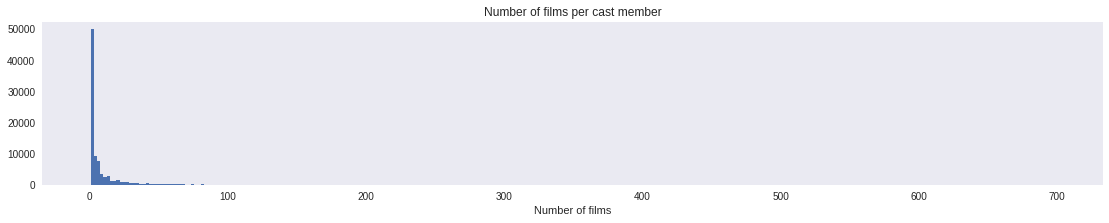

In [0]:
figure, axes = plt.subplots(1,1)

num_bins = int(np.sqrt(len(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].unique())))
plt.hist(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts(), bins=num_bins);

plt.grid(False);
plt.xlabel('Number of films');
plt.title('Number of films per cast member');
#plt.xlim(,);
#plt.ylim(,);
figure.set_size_inches([19,3])

plt.show()

30,568 out of 88,541 cast members have only worked in 1 movie! And a few of them have worked in more than 100 movies. It is a very skewed distribution.

In [0]:
dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts().describe()

count    88541.000000
mean         8.825245
std         17.036559
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        698.000000
Name: people_id, dtype: float64

In [0]:
#Top 10 cast members according to the number of movies they worked on:
dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts().head(10)

33923     698
124097    540
121323    528
55680     482
130111    353
42545     313
21315     290
15831     265
89153     260
932309    253
Name: people_id, dtype: int64

In [0]:
#Volume of cast members according to the number of movies they have worked on:
pd.Series(dfPeopleMoviesCast.merge(dfCastIds, how='inner')['people_id'].value_counts()).value_counts().head(10)

1     30568
2     11878
3      7364
4      5290
5      3869
6      3055
7      2540
8      2110
9      1724
10     1605
Name: people_id, dtype: int64

So we would like to cluster our cast members according to the number of movies they have worked on. There are two interesting features to consider about it: the budget of the movies they have worked on and the importance of their role. But we don´t have **`budget`** or **`order`** in **`dfPeopleMoviesCast`**. We will need to take this information importing again the whole origina set of movies.

###Importing all movies to get budget and order information.

We will create dfMoviesAll dataframe to store this information. In this case, we will reduce the number of fields to import.

In [0]:
def moviesIterator(path):
    intI = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            intI += 1
            if f.endswith('.json'):
                fp = os.path.join(root,f)
                with open(fp) as o:
                    data = ujson.load(o)
                
                if intI % 25000 == 0:
                    print(intI)
                    
                result = {"budget": data["budget"], "credits_cast": data["credits"]["cast"], 
                          "credits_crew": data["credits"]["crew"], "movie_id": data["id"], "imdb_id": data["imdb_id"]}                
                 
                if data["adult"] == False:
                    yield result

In [0]:
#Approximate execution time in Google Colab: 6min
path = "./themoviedb_data/movies"
dfMoviesAll = pd.DataFrame()
tic=timeit.default_timer()
dfMoviesAll = pd.DataFrame(moviesIterator(path))
toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
6.342429324116665  min


In [0]:
dfMoviesAll.shape

(393239, 5)

In [0]:
dfMoviesAll.columns

Index(['budget', 'credits_cast', 'credits_crew', 'imdb_id', 'movie_id'], dtype='object')

In [0]:
def columnIteratorMoviesAll(columnName, *args):
    for id in dfMoviesAll.index:
        for dict in dfMoviesAll[dfMoviesAll.index == id][columnName].iloc[0]:
            outputDict = {'movie_id': id}
            for key in args:
                outputDict[key] = dict.get(key,None)
            yield outputDict

def columnProcessesMoviesAll (columnName, *args):
    #We need to declare dfMoviesAll as global as we will change it inside this function.
    global dfMoviesAll
    
    dfOutput = pd.DataFrame()
    dfOutput = pd.DataFrame(columnIteratorMoviesAll(columnName, *args))
    
    #Sanity check:
    dfCheck = pd.DataFrame(dfMoviesAll[columnName].map(len).value_counts())
    dfCheck['calculation']=dfCheck[columnName]*dfCheck.index
    
    if dfOutput.shape[0] == dfCheck['calculation'].sum():
        dfMoviesAll = dfMoviesAll.drop(columnName, axis=1)
        return dfOutput
    else:
        return "Error in process"             

In [0]:
#This module takes less about 12min to be executed in Google Colab.

#Firstly we need movies ids to be the index of dfMoviesAll.
dfMoviesAll.index = dfMoviesAll['movie_id']

tic=timeit.default_timer()

dfMoviesAllCast = columnProcessesMoviesAll ('credits_cast', 'cast_id', 'character', 'gender', 'id', 'name', 'order')
print("dfMoviesAllCast generated")

dfMoviesAllCrew = columnProcessesMoviesAll ('credits_crew', 'department', 'gender', 'id', 'job', 'name')
print("dfMoviesAllCrew generated")

toc=timeit.default_timer()
print((toc - tic)/60, ' min') #elapsed time in minutes

dfMoviesAllCast generated
dfMoviesAllCrew generated
12.103061210466665  min


Merging with IMDb information:

In [0]:
my_file_path='./IMDB_5000_movie.csv'

#Reading file and saving in df
dfMovies5000 = pd.read_csv(my_file_path)

#Let's create a new column in dfMovies5000 with IMDb identifier:
dfMovies5000['imdb_id'] = dfMovies5000['movie_imdb_link'].str.split("/").map(lambda list: list[4])

#Removing duplicates:
dfMovies5000 = dfMovies5000.drop_duplicates(subset='imdb_id', keep='first')

#Let´s clean up the '' to null values:
dfMoviesAll['imdb_id']=dfMoviesAll['imdb_id'].map(lambda x: None if x=='' else x)

#Renaming before merging:
dfMovies5000 = dfMovies5000.rename(columns={'gross': 'imdb_revenue', 'budget': 'imdb_budget'})

#Merging:
dfMoviesAll = dfMoviesAll.merge(dfMovies5000[['imdb_id', 'imdb_revenue', 'imdb_budget']], how='left', on='imdb_id')

#Converting 0's to null values:
dfMoviesAll['budget'] = dfMoviesAll['budget'].map(lambda num: None if num != num or num is None or num==0 else num)

In [0]:
#Removing blank positions in strings:

for column in dfMoviesAllCast.columns[dfMoviesAllCast.dtypes == 'object']:
    dfMoviesAllCast[column] = dfMoviesAllCast[column].str.strip()

for column in dfMoviesAllCrew.columns[dfMoviesAllCrew.dtypes == 'object']:
    dfMoviesAllCrew[column] = dfMoviesAllCrew[column].str.strip()

print('All blanks cleaned up') 

All blanks cleaned up


In [0]:
#Removing duplicates in our primary keys:
dfMoviesAllCast = dfMoviesAllCast.drop_duplicates(subset=['movie_id', 'id'], keep='first')
dfMoviesAllCrew = dfMoviesAllCrew.drop_duplicates(subset=['movie_id', 'id', 'job'], keep='first')

Budget quality check:

In [0]:
#We are going to add two columns that will keep the original values we got and that we are about to change:
dfMoviesAll['budget_tmdb_corrected'] = None
dfMoviesAll['budget_imdb_corrected'] = None

#We keep memory of the values we are about to change (values lower than $200):
dfMoviesAll.loc[dfMoviesAll['budget']<200, 'budget_tmdb_corrected'] = dfMoviesAll.loc[dfMoviesAll['budget']<200, 'budget']
dfMoviesAll.loc[dfMoviesAll['imdb_budget']<200, 'budget_imdb_corrected'] = dfMoviesAll.loc[dfMoviesAll['imdb_budget']<200, 'imdb_budget']

#We make null values lower than $200:
dfMoviesAll.loc[dfMoviesAll['budget']<200, 'budget'] = None
dfMoviesAll.loc[dfMoviesAll['imdb_budget']<200, 'imdb_budget'] = None 

#We take as our valid value to work with the one from our original source TMDB, unless is null, then we take IMDB one.
dfMoviesAll['budget_final'] = dfMoviesAll['budget'].combine_first(dfMoviesAll['imdb_budget'])

###Continuing with feature engineering for cast information.

In [0]:
#Nulls?
dfMoviesAll.isnull().sum()

budget                   376445
imdb_id                  101697
movie_id                      0
imdb_revenue             389188
imdb_budget              388825
budget_tmdb_corrected    391512
budget_imdb_corrected    393239
budget_final             375739
dtype: int64

Let's bring a file with an inflation US dollar factor per year (source https://www.usinflationcalculator.com/) that will let us convert all revenue and budget information to 2018 baseline.

In [0]:
my_file_path='./InflationConverter.xlsx'
dfInflationConverter = pd.read_excel(my_file_path)
dfInflationConverter.shape

(106, 2)

In [0]:
dfInflationConverter.head(5)

,Year,InflationConverter
0,2018,100.00
1,2017,102.99
2,2016,105.18
3,2015,106.51
4,2014,106.63


In [0]:
dfInflationConverter.tail(5)

,Year,InflationConverter
101,1917,1972.18
102,1916,2315.95
103,1915,2499.40
104,1914,2524.39
105,1913,2549.89


First year in this dataframe es 1913. All other years will be excluded when merging.

Our goal now is to include information of budget and cast order in **`dfPeopleMoviesCast`**, where we have all the information of the movies where our cast members have worked on. This dataframe will be the base for our actors clustering.

In [0]:
dfPeopleMoviesCast.shape

(878146, 12)

In order to make script programming simpler, we will do:

In [0]:
#So we get exclusively the information about cast members in our movies universe:
dfPeopleMoviesCast = dfPeopleMoviesCast.merge(dfCastIds, how='inner')
dfPeopleMoviesCast.shape

(781396, 12)

In [0]:
#Now we include budget information:
dfPeopleMoviesCast = dfPeopleMoviesCast.merge(dfMoviesAll[['movie_id','budget_final']], how='left', left_on='id', right_on='movie_id').drop('movie_id', axis=1)
dfPeopleMoviesCast.shape

(781396, 13)

In [0]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final'],
      dtype='object')

In [0]:
#This is the expected number of rows to be excluded when merging with inflation information:
dfPeopleMoviesCast[(dfPeopleMoviesCast['release_date'].isnull()) | (dfPeopleMoviesCast['release_date']<'1913-01-01') | (dfPeopleMoviesCast['release_date']>'2018-12-31')].shape[0]

10329

In [0]:
#Adding the year:
dfPeopleMoviesCast['release_year'] = dfPeopleMoviesCast['release_date'].map(lambda datetime: datetime.year)
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year'],
      dtype='object')

In [0]:
dfPeopleMoviesCast[['release_year', 'release_date']].isnull().sum()

release_year    8563
release_date    8563
dtype: int64

In [0]:
#Lets check the expected number of rows of our merge:
dfPeopleMoviesCast.merge(dfInflationConverter, how='inner', left_on='release_year', right_on='Year').shape

(771067, 16)

In [0]:
#That is what we expected:
781396-10329

771067

In [0]:
#Merging with inflation converter:
dfPeopleMoviesCast = dfPeopleMoviesCast.merge(dfInflationConverter, how='inner', left_on='release_year', right_on='Year').drop('Year', axis=1)
dfPeopleMoviesCast.shape

(771067, 15)

In [0]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter'],
      dtype='object')

In [0]:
#And now we get to the budget according to 2018 baseline:
dfPeopleMoviesCast['budget_converted'] = dfPeopleMoviesCast['budget_final'] * dfPeopleMoviesCast['InflationConverter']/100

In [0]:
dfPeopleMoviesCast[['budget_final', 'InflationConverter', 'budget_converted']].head()

,budget_final,InflationConverter,budget_converted
0,NaN,650.62,NaN
1,400000.0,650.62,2602480.0
2,NaN,650.62,NaN
3,NaN,650.62,NaN
4,5000000.0,650.62,32531000.0


In [0]:
dfPeopleMoviesCast[['budget_final', 'InflationConverter', 'budget_converted']].isnull().sum()

budget_final          577548
InflationConverter         0
budget_converted      577548
dtype: int64

In [0]:
dfPeopleMoviesCast[['budget_final', 'budget_converted']].describe()

,budget_final,budget_converted
count,1.935190e+05,1.935190e+05
mean,3.459291e+07,4.615705e+07
std,6.227702e+07,7.670061e+07
min,2.000000e+02,2.059800e+02
25%,5.000000e+06,8.365392e+06
50%,1.600000e+07,2.556750e+07
75%,4.000000e+07,6.087500e+07
max,4.200000e+09,5.428920e+09


Now we will update all null values in **`budget_converted`** with the median of all movies. We are introducing here a bias diffcult to estimate. We leave this point as something to improve in the future.

In [0]:
#We will get the median from every movie, not from every tuple movie-cast member:
auxBudgetMedian = dfPeopleMoviesCast.drop_duplicates(subset='id', keep='first')['budget_converted'].median()
auxBudgetMedian

6909900.0

In [0]:
#Let's firstly have a look to the effect of this change:
dfPeopleMoviesCast.fillna({'budget_converted': auxBudgetMedian}).describe()

,id,people_id,popularity,vote_average,vote_count,budget_final,InflationConverter,budget_converted
count,771067.000000,7.710670e+05,771067.000000,771067.000000,771067.000000,1.935190e+05,771067.000000,7.710670e+05
mean,172664.573865,2.903309e+05,2.869695,4.747117,334.257810,3.459291e+07,314.387772,1.675998e+07
std,158208.611502,5.036102e+05,5.530897,2.748452,1239.404726,6.227702e+07,388.292640,4.202432e+07
min,2.000000,1.000000e+00,0.000000,0.000000,0.000000,2.000000e+02,100.000000,2.059800e+02
25%,32241.000000,1.700500e+04,0.148000,3.600000,1.000000,5.000000e+06,112.230000,6.909900e+06
50%,113225.000000,6.207000e+04,0.750000,5.800000,5.000000,1.600000e+07,142.620000,6.909900e+06
75%,297596.000000,1.544950e+05,4.050000,6.700000,63.000000,4.000000e+07,253.450000,6.909900e+06
max,546336.000000,2.115927e+06,253.501000,10.000000,18623.000000,4.200000e+09,2549.890000,5.428920e+09


In [0]:
#And now let´s perform the commented change:
dfPeopleMoviesCast = dfPeopleMoviesCast.fillna({'budget_converted': auxBudgetMedian})

In [0]:
#Now we will perform a cluster of movies according to their budget:
dfAuxMoviesBudget = dfPeopleMoviesCast.drop_duplicates(subset='id', keep='first')[['id', 'budget_converted']]
dfAuxMoviesBudget.shape

(166392, 2)

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(dfAuxMoviesBudget[['budget_converted']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [0]:
dfAuxMoviesBudget['cluster'] = kmeans.predict(dfAuxMoviesBudget[['budget_converted']])

In [0]:
dfAuxMoviesBudget.groupby('cluster')['budget_converted'].agg(['min','max','count'])

,min,max,count
cluster,,,
0,6.172650e+07,1.084090e+09,1457
1,2.059800e+02,6.157200e+07,164933
2,3.231500e+09,5.428920e+09,2


In [0]:
#One of the clusters have only 2 movies! Let's have a look to them:
dfAuxMoviesBudget[dfAuxMoviesBudget['budget_converted']>2e9]['id']

354152     4550
361695    41508
Name: id, dtype: int64

In [0]:
#They seem to be errors. Specially considering that Avatar is the most expensive movie in the history, with a budget of $425,000,000
dfPeopleMoviesCast.drop_duplicates(subset='id', keep='first')[(dfPeopleMoviesCast['id']==41508) | (dfPeopleMoviesCast['id']==4550)][['title', 'release_date', 'original_title', 'popularity']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,title,release_date,original_title,popularity
354152,Sympathy for Lady Vengeance,2005-09-30,친절한 금자씨,7.694
361695,Fateless,2005-02-10,Sorstalanság,2.335


In [0]:
#We will exclude those 2 records and cluster again:
dfAuxMoviesBudget = dfAuxMoviesBudget.drop(dfAuxMoviesBudget[dfAuxMoviesBudget['budget_converted']>2e9].index)

In [0]:
#But in this case, considering that budget is a ver skewed feature, we will apply clustering over log(budget):

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(dfAuxMoviesBudget[['budget_converted']].applymap(np.log))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [0]:
dfAuxMoviesBudget['cluster'] = kmeans.predict(dfAuxMoviesBudget[['budget_converted']].applymap(np.log))
dfAuxMoviesBudget.groupby('cluster')['budget_converted'].agg(['min','max','count', 'mean', 'median'])

,min,max,count,mean,median
cluster,,,,,
0,466937.60,1.788570e+07,159738,6.859855e+06,6909900.0
1,205.98,4.646100e+05,2215,1.138715e+05,53255.0
2,17912510.00,1.084090e+09,4437,6.104543e+07,42490800.0


We could say that cluster 1 is made of low budget movies and cluster 2 is made of big productions. We will keep this criteria and so we will use $18 million as the threshold to split between big productions and others.

Now we need to get cast order information. We have it in **`dfMoviesAllCast`**.

In [0]:
dfMoviesAllCast.columns

Index(['cast_id', 'character', 'gender', 'id', 'movie_id', 'name', 'order'], dtype='object')

In [0]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter', 'budget_converted'],
      dtype='object')

In [0]:
dfPeopleMoviesCast.shape

(771067, 16)

In [0]:
#Let's check how many rows merge:
dfPeopleMoviesCast.merge(dfMoviesAllCast, how='inner', left_on=['id','people_id'], right_on=['movie_id', 'id']).shape

(763535, 23)

In [0]:
#Let's do the merge:
dfPeopleMoviesCast = dfPeopleMoviesCast.merge(dfMoviesAllCast[['movie_id', 'id', 'order']], how='left', left_on=['id','people_id'], right_on=['movie_id', 'id']).drop(['movie_id', 'id_y'], axis=1).rename(columns={'id_x': 'id'})
dfPeopleMoviesCast.shape

(771067, 17)

In [0]:
dfPeopleMoviesCast.shape

(771067, 17)

In [0]:
dfPeopleMoviesCast.describe()

,id,people_id,popularity,vote_average,vote_count,budget_final,InflationConverter,budget_converted,order
count,771067.000000,7.710670e+05,771067.000000,771067.000000,771067.000000,1.935190e+05,771067.000000,7.710670e+05,763535.000000
mean,172664.573865,2.903309e+05,2.869695,4.747117,334.257810,3.459291e+07,314.387772,1.675998e+07,9.488302
std,158208.611502,5.036102e+05,5.530897,2.748452,1239.404726,6.227702e+07,388.292640,4.202432e+07,14.191721
min,2.000000,1.000000e+00,0.000000,0.000000,0.000000,2.000000e+02,100.000000,2.059800e+02,0.000000
25%,32241.000000,1.700500e+04,0.148000,3.600000,1.000000,5.000000e+06,112.230000,6.909900e+06,2.000000
50%,113225.000000,6.207000e+04,0.750000,5.800000,5.000000,1.600000e+07,142.620000,6.909900e+06,5.000000
75%,297596.000000,1.544950e+05,4.050000,6.700000,63.000000,4.000000e+07,253.450000,6.909900e+06,11.000000
max,546336.000000,2.115927e+06,253.501000,10.000000,18623.000000,4.200000e+09,2549.890000,5.428920e+09,313.000000


Now we will define the variables that we will use to cluster our cast members: 
1. Big production (budget > $18 million), small production (all others)
2. Important role (cast order from 0 to 4), other roles (all others)

In [0]:
#Assumed error: order does not always start on 0
dfPeopleMoviesCast['leadingRole_BigProduc'] = (dfPeopleMoviesCast['order']<5) & (dfPeopleMoviesCast['budget_converted']>18e6)
dfPeopleMoviesCast['leadingRole_SmallProduc'] = (dfPeopleMoviesCast['order']<5) & (dfPeopleMoviesCast['budget_converted']<=18e6)
dfPeopleMoviesCast['minorRole_BigProduc'] = (dfPeopleMoviesCast['order']>=5) & (dfPeopleMoviesCast['budget_converted']>18e6)
dfPeopleMoviesCast['minorRole_SmallProduc'] = (dfPeopleMoviesCast['order']>=5) & (dfPeopleMoviesCast['budget_converted']<=18e6)

In [0]:
dfPeopleMoviesCast.columns

Index(['adult', 'character', 'genre_ids', 'id', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final', 'release_year',
       'InflationConverter', 'budget_converted', 'order',
       'leadingRole_BigProduc', 'leadingRole_SmallProduc',
       'minorRole_BigProduc', 'minorRole_SmallProduc'],
      dtype='object')

In [0]:
#We will create dfAuxPeopleCluster dataframe, that will be the base for our cast members clustering:
dfAuxPeopleCluster = dfPeopleMoviesCast.groupby('people_id')[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].sum().reset_index()
dfAuxPeopleCluster.shape

(88541, 5)

In [0]:
dfAuxPeopleCluster.head()

,people_id,leadingRole_BigProduc,leadingRole_SmallProduc,minorRole_BigProduc,minorRole_SmallProduc
0,1,0.0,35.0,4.0,22.0
1,2,5.0,70.0,3.0,32.0
2,3,38.0,22.0,4.0,34.0
3,4,8.0,39.0,8.0,26.0
4,5,3.0,82.0,1.0,20.0


In [0]:
dfAuxPeopleCluster.describe()

,people_id,leadingRole_BigProduc,leadingRole_SmallProduc,minorRole_BigProduc,minorRole_SmallProduc
count,8.854100e+04,88541.000000,88541.000000,88541.000000,88541.000000
mean,8.583617e+05,0.238703,3.654906,1.060876,3.669035
std,7.330149e+05,1.525123,10.055673,1.672030,7.620338
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,8.617800e+04,0.000000,0.000000,0.000000,0.000000
50%,1.047642e+06,0.000000,0.000000,1.000000,1.000000
75%,1.529406e+06,0.000000,2.000000,1.000000,4.000000
max,2.115927e+06,62.000000,672.000000,74.000000,498.000000


So we have defined the features above for every cast member and now we can cluster them accordingly. As they are considerably right skewed features, we will firsty apply log(1+x) transformation.

(We tried to the clustering previously applying a robust scaler, what should be expected to be necessary. Anyways, after checking the results, we prefered the results of the clustering below, with more balanced volume of the clusters and differences between mean and median very acceptable. We will do the same later on with crew clustering. )

In [0]:
from sklearn.cluster import KMeans

kmeansPeople = KMeans(n_clusters=3, random_state=0)
kmeansPeople.fit(dfAuxPeopleCluster[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].applymap(lambda x: np.log(x+1)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [0]:
dfAuxPeopleCluster['cluster'] = kmeansPeople.predict(dfAuxPeopleCluster[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].applymap(lambda x: np.log(x+1)))
dfAuxPeopleCluster.groupby('cluster')[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].agg(['min','max','count', 'median', 'mean'])

leadingRole_BigProduc                                \
                          min   max  count median      mean   
cluster                                                       
0                         0.0   8.0  52280    0.0  0.014652   
1                         0.0  62.0  12322    0.0  1.504464   
2                         0.0  14.0  23939    0.0  0.076486   

        leadingRole_SmallProduc                                  \
                            min    max  count median       mean   
cluster                                                           
0                           0.0    5.0  52280    0.0   0.188332   
1                           1.0  672.0  12322   14.0  20.638370   
2                           0.0   21.0  23939    2.0   2.483688   

        minorRole_BigProduc                                \
                        min   max  count median      mean   
cluster                                                     
0                       0.0  15.0  52280    1.0  0.742445   
1                       0.0  74.0  12322    1.0  2.440026   
2                       0.0  42.0  23939    1.0  1.046410   

        minorRole_SmallProduc                                  
                          min    max  count median       mean  
cluster                                                        
0                         0.0    3.0  52280    1.0   0.748699  
1                         0.0  498.0  12322   10.0  14.132121  
2                         0.0  134.0  23939    4.0   4.661097

We could say cluster 1 could be made of stars, cluster 0 could be made of non frequent actors and cluster 2 would be made of all others. We see that the volumes of this clusters are big enough to be used later on feature engineering.

Now we will apply this information to add features to **`dfMoviesUS`**. Firstly we need to create **`dfTmp`** dataframe, which will store for every movie and cast member the four features leadingRole_BigProduc, leadingRole_SmallProduc, minorRole_BigProduc, minorRole_SmallProduc calculated **considering the work of every cast member previously to that movie**. Besides, **`dfTmp`** includes cast order in that movie.

In [0]:
dfTmp = dfMoviesUS[['movie_id', 'release_date']].merge(dfMoviesCast[['movie_id', 'id', 'gender', 'order']], how='left', on='movie_id').rename(columns={'id': 'people_id'}).merge(dfPeopleMoviesCast[['id', 'people_id', 'release_date', 'leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']], how='left', on='people_id')[dfMoviesUS[['movie_id', 'release_date']].merge(dfMoviesCast[['movie_id', 'id', 'gender', 'order']], how='left', on='movie_id').rename(columns={'id': 'people_id'}).merge(dfPeopleMoviesCast[['id', 'people_id', 'release_date', 'leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']], how='left', on='people_id')['release_date_y']<dfMoviesUS[['movie_id', 'release_date']].merge(dfMoviesCast[['movie_id', 'id', 'gender', 'order']], how='left', on='movie_id').rename(columns={'id': 'people_id'}).merge(dfPeopleMoviesCast[['id', 'people_id', 'release_date', 'leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']], how='left', on='people_id')['release_date_x']].groupby(['movie_id', 'people_id', 'order'])[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].sum().reset_index()

In [0]:
dfTmp.shape

(133409, 7)

In [0]:
dfTmp.columns

Index(['movie_id', 'people_id', 'order', 'leadingRole_BigProduc',
       'leadingRole_SmallProduc', 'minorRole_BigProduc',
       'minorRole_SmallProduc'],
      dtype='object')

In [0]:
dfTmp.head()

,movie_id,people_id,order,leadingRole_BigProduc,leadingRole_SmallProduc,minorRole_BigProduc,minorRole_SmallProduc
0,5,62.0,5.0,13,9,1,6
1,5,138.0,6.0,0,7,0,6
2,5,2545.0,11.0,0,0,0,4
3,5,2555.0,14.0,0,7,3,3
4,5,3122.0,7.0,0,13,0,2


So **`dfTmp`** has the information we need to cluster our cast members considering their story up to that movie:

In [0]:
dfTmp['cluster'] = kmeansPeople.predict(dfTmp[['leadingRole_BigProduc', 'leadingRole_SmallProduc', 'minorRole_BigProduc', 'minorRole_SmallProduc']].applymap(lambda x: np.log(x+1)))

In [0]:
dfTmp['cluster'].value_counts()

0    46250
2    45966
1    41193
Name: cluster, dtype: int64

Now we define the features we will add to **`dfMoviesUS`**:

In [0]:
dfTmp['3FirstRoles_High'] = (dfTmp['order']<3) & (dfTmp['cluster']==1)
dfTmp['3FirstRoles_Medium'] = (dfTmp['order']<3) & (dfTmp['cluster']==2)
dfTmp['3FirstRoles_Low'] = (dfTmp['order']<3) & (dfTmp['cluster']==0)
dfTmp['OtherRoles_High'] = (dfTmp['order']>=3) & (dfTmp['cluster']==1)
dfTmp['OtherRoles_Medium'] = (dfTmp['order']>=3) & (dfTmp['cluster']==2)
dfTmp['OtherRoles_Low'] = (dfTmp['order']>=3) & (dfTmp['cluster']==0)    

And *aux* function will help us to group information in **`dfTmp`** and add it to **`dfMoviesUS`** at movie-id level:

In [0]:
def aux():
    global dfMoviesUS
    dfTmp2 = pd.DataFrame()
    dfTmp2 = dfTmp.groupby('movie_id')[['3FirstRoles_High', '3FirstRoles_Medium', '3FirstRoles_Low', 'OtherRoles_High', 'OtherRoles_Medium', 'OtherRoles_Low']].sum().reset_index()
    dfMoviesUS = dfMoviesUS.merge(dfTmp2, how='left', on='movie_id')
    dfMoviesUS = dfMoviesUS.fillna({'3FirstRoles_High': 0, '3FirstRoles_Medium': 0, '3FirstRoles_Low': 0, 'OtherRoles_High': 0, 'OtherRoles_Medium': 0, 'OtherRoles_Low': 0})    

In [0]:
aux()

In [0]:
dfMoviesUS.shape

(8373, 34)

In [0]:
dfMoviesUS.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'imdb_id', 'movie_id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'reviews_page',
       'reviews_total_pages', 'reviews_total_results', 'runtime', 'status',
       'tagline', 'title', 'titles', 'vote_average', 'vote_count',
       'imdb_revenue', 'imdb_budget', 'revenue_final', 'budget_final',
       'revenue_tmdb_corrected', 'revenue_imdb_corrected',
       'budget_tmdb_corrected', '3FirstRoles_High', '3FirstRoles_Medium',
       '3FirstRoles_Low', 'OtherRoles_High', 'OtherRoles_Medium',
       'OtherRoles_Low'],
      dtype='object')

In [0]:
dfMoviesUS[['3FirstRoles_High', '3FirstRoles_Medium', '3FirstRoles_Low', 'OtherRoles_High', 'OtherRoles_Medium', 'OtherRoles_Low']].head()

,3FirstRoles_High,3FirstRoles_Medium,3FirstRoles_Low,OtherRoles_High,OtherRoles_Medium,OtherRoles_Low
0,2.0,1.0,0.0,0.0,1.0,0.0
1,3.0,0.0,0.0,3.0,8.0,8.0
2,0.0,1.0,2.0,0.0,1.0,1.0
3,2.0,1.0,0.0,1.0,10.0,2.0
4,1.0,1.0,0.0,0.0,6.0,2.0


In [0]:
#Looking at one example: "Mad Max, Fury Road"
dfMoviesUS[dfMoviesUS['movie_id']==76341][['3FirstRoles_High', '3FirstRoles_Medium', '3FirstRoles_Low', 'OtherRoles_High', 'OtherRoles_Medium', 'OtherRoles_Low']]

,3FirstRoles_High,3FirstRoles_Medium,3FirstRoles_Low,OtherRoles_High,OtherRoles_Medium,OtherRoles_Low
1952,3.0,0.0,0.0,5.0,12.0,10.0


##7.06 Feature engineering from all other columns.

###7.06.01 Inflation adjustment to revenue and budget.

In order to be able to use information of revenue and budget in our model, we need to adjust our values to the same baseline. We will take 2018 as baseline and will use **`dfInflationConverter`** got from https://www.usinflationcalculator.com/. 

In [0]:
dfInflationConverter.shape

(106, 2)

In [0]:
dfInflationConverter.tail()

,Year,InflationConverter
101,1917,1972.18
102,1916,2315.95
103,1915,2499.40
104,1914,2524.39
105,1913,2549.89


In [0]:
dfMoviesUS.shape

(8373, 34)

In [0]:
#Let's change the name of columns 'revenue_final' and 'budget_final' to a most appropiate one:
dfMoviesUS = dfMoviesUS.rename(columns={'revenue_final': 'revenue_tmdb_imdb', 'budget_final': 'budget_tmdb_imdb'})

In [0]:
dfMoviesUS['release_year'] = dfMoviesUS['release_date'].map(lambda datetime: datetime.year)
dfMoviesUS['release_month'] = dfMoviesUS['release_date'].map(lambda datetime: str(datetime.month))
dfMoviesUS.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'imdb_id', 'movie_id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'reviews_page',
       'reviews_total_pages', 'reviews_total_results', 'runtime', 'status',
       'tagline', 'title', 'titles', 'vote_average', 'vote_count',
       'imdb_revenue', 'imdb_budget', 'revenue_tmdb_imdb', 'budget_tmdb_imdb',
       'revenue_tmdb_corrected', 'revenue_imdb_corrected',
       'budget_tmdb_corrected', '3FirstRoles_High', '3FirstRoles_Medium',
       '3FirstRoles_Low', 'OtherRoles_High', 'OtherRoles_Medium',
       'OtherRoles_Low', 'release_year', 'release_month'],
      dtype='object')

In [0]:
dfMoviesUS = dfMoviesUS.merge(dfInflationConverter, how='inner', left_on='release_year', right_on='Year').drop('Year', axis=1)

In [0]:
dfMoviesUS['InflationConverter'].isnull().sum()

0

In [0]:
dfMoviesUS['revenue_inflation_adjusted'] = dfMoviesUS['revenue_tmdb_imdb'] * dfMoviesUS['InflationConverter']/100
dfMoviesUS['budget_inflation_adjusted'] = dfMoviesUS['budget_tmdb_imdb'] * dfMoviesUS['InflationConverter']/100
dfMoviesUS[['revenue_inflation_adjusted', 'budget_inflation_adjusted', 'revenue_tmdb_imdb', 'budget_tmdb_imdb']].isnull().sum()

revenue_inflation_adjusted       0
budget_inflation_adjusted     2131
revenue_tmdb_imdb                0
budget_tmdb_imdb              2131
dtype: int64

In [0]:
#0's?
dfMoviesUS[['revenue_inflation_adjusted', 'budget_inflation_adjusted', 'revenue_tmdb_imdb', 'budget_tmdb_imdb']].applymap(lambda x: x==0).sum()

revenue_inflation_adjusted    0
budget_inflation_adjusted     0
revenue_tmdb_imdb             0
budget_tmdb_imdb              0
dtype: int64

###7.06.02 Genres

In [0]:
#Let's check:
print(dfMoviesGenres[['movie_id', 'id']].duplicated().sum())
print(dfMoviesGenres[['movie_id', 'name']].duplicated().sum())
print(dfMoviesGenres['id'].duplicated().sum())
print(dfMoviesGenres['name'].duplicated().sum())
print(dfMoviesGenres[['id','name']].duplicated().sum())

0
0
21778
21778
21778


In [0]:
#Do we have movies without genre?:
dfMoviesUS.merge(dfMoviesGenres, how='left', on='movie_id').drop_duplicates(subset='movie_id', keep='first')['name'].isnull().sum()

42

In [0]:
dfMoviesGenres.merge(dfMoviesUS, how='inner', on='movie_id')['name'].value_counts()

Drama              4263
Comedy             3055
Thriller           2076
Action             1823
Romance            1652
Adventure          1213
Crime              1200
Horror              855
Science Fiction     827
Family              809
Fantasy             695
Mystery             669
Animation           422
History             349
Music               319
Documentary         306
War                 260
Western             125
TV Movie              6
Name: name, dtype: int64

In [0]:
#At the moment, we add a column for every genre.
for genre in dfMoviesGenres.merge(dfMoviesUS, how='inner', on='movie_id')['name'].unique():
    dfMoviesUS['IND_'+genre]=0

In [0]:
#How many different genres can a movie have?
dfMoviesGenres.merge(dfMoviesUS, how='inner', on='movie_id').groupby('movie_id')['status'].count().reset_index().groupby('status')['movie_id'].count()

status
1    1643
2    2739
3    2466
4    1084
5     332
6      61
7       5
8       1
Name: movie_id, dtype: int64

In [0]:
#What kind of genres combinations do we have?
def update_genres():
    for genre in dfMoviesGenres.merge(dfMoviesUS, how='inner', on='movie_id')['name'].unique():
        genres_ids_list = dfMoviesGenres[dfMoviesGenres['name']==genre].merge(dfMoviesUS, how='inner', on='movie_id')['movie_id'].tolist()
        dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(genres_ids_list), 'IND_'+genre] = 1

update_genres()        

In [0]:
#Is that what we expected to have?
dfMoviesUS[dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND_')]].sum()

IND_Drama              4263
IND_Romance            1652
IND_Comedy             3055
IND_Action             1823
IND_Thriller           2076
IND_History             349
IND_Crime              1200
IND_Science Fiction     827
IND_Adventure          1213
IND_Documentary         306
IND_Horror              855
IND_Family              809
IND_Animation           422
IND_Mystery             669
IND_Music               319
IND_Fantasy             695
IND_Western             125
IND_War                 260
IND_TV Movie              6
dtype: int64

In [0]:
#And now we can see the different possible combinations:
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND_')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,IND_Drama,IND_Romance,IND_Comedy,IND_Action,IND_Thriller,IND_History,IND_Crime,IND_Science Fiction,IND_Adventure,IND_Documentary,IND_Horror,IND_Family,IND_Animation,IND_Mystery,IND_Music,IND_Fantasy,IND_Western,IND_War,IND_TV Movie,status
480,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,697
242,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,478
674,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,393
744,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,382
829,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,356
439,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,294
27,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,198
102,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,155
586,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,143
564,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,142


The script below allow us to export the table above to excel for a more comfortable analysis:

In [0]:
!pip install openpyxl
import openpyxl

dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND_')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False).to_excel('genres.xlsx')
!cp genres.xlsx /content/drive/"My Drive"

    100% |████████████████████████████████| 174kB 4.7MB/s 
  Running setup.py bdist_wheel for openpyxl ... - \ | error
  Complete output from command /usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-eybmf_bt/openpyxl/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-gojlkmsw --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/openpyxl
  copying openpyxl/__init__.py -> build/lib/openpyxl
  copying openpyxl/_constants.py -> build/lib/openpyxl
  copying openpyxl/conftest.py -> build/lib/openpyxl
  creating build/lib/openpyxl/styles
  copying openpyxl/styles/borders.py -> build/lib/openpyxl/styles
  copying openpyxl/styles/numbers.py -> build/lib/openpyxl/styles
  copying openpyxl/styles/stylesheet.py -> build/lib/openpyxl/styles
  copying openpyxl/styles/

After analyzing the different combinations, we group de genres with the following criteria:

In [0]:
dfMoviesUS['indAnimationMusic']=0
dfMoviesUS['indFantasyScienceFiction']=0
dfMoviesUS['indDocumentaryHistoryWar']=0
dfMoviesUS['indRomance']=0
dfMoviesUS['indComedy']=0
dfMoviesUS['indThrillerHorrorActionCrimeMystery']=0
dfMoviesUS['indDrama']=0

In [0]:
dfMoviesUS.loc[(dfMoviesUS['IND_Animation']==1) | (dfMoviesUS['IND_Music']==1), 'indAnimationMusic'] = 1
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & 
               ((dfMoviesUS['IND_Fantasy']==1) | (dfMoviesUS['IND_Science Fiction']==1)), 
               'indFantasyScienceFiction'] = 1
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & 
               ((dfMoviesUS['IND_Documentary']==1) | (dfMoviesUS['IND_History']==1) | (dfMoviesUS['IND_War']==1)), 
               'indDocumentaryHistoryWar'] = 1
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) &
               (dfMoviesUS['IND_Romance']==1), 
               'indRomance'] = 1
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) &
               (dfMoviesUS['indRomance']==0) & (dfMoviesUS['IND_Comedy']==1), 
               'indComedy'] = 1
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) &
               (dfMoviesUS['indRomance']==0) & (dfMoviesUS['indComedy']==0) & 
               ((dfMoviesUS['IND_Thriller']==1) | (dfMoviesUS['IND_Horror']==1) | (dfMoviesUS['IND_Action']==1) | 
                (dfMoviesUS['IND_Crime']==1) | (dfMoviesUS['IND_Mystery']==1)), 
               'indThrillerHorrorActionCrimeMystery'] = 1
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) &
               (dfMoviesUS['indRomance']==0) & (dfMoviesUS['indComedy']==0) & (dfMoviesUS['indThrillerHorrorActionCrimeMystery']==0) &
               (dfMoviesUS['IND_Drama']==1), 
               'indDrama'] = 1

In [0]:
dfMoviesUS[dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('ind')]].sum()

indAnimationMusic                       712
indFantasyScienceFiction               1165
indDocumentaryHistoryWar                736
indRomance                             1326
indComedy                              1601
indThrillerHorrorActionCrimeMystery    1958
indDrama                                787
dtype: int64

In [0]:
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('ind')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,indAnimationMusic,indFantasyScienceFiction,indDocumentaryHistoryWar,indRomance,indComedy,indThrillerHorrorActionCrimeMystery,indDrama,status
2,0,0,0,0,0,1,0,1958
3,0,0,0,0,1,0,0,1601
4,0,0,0,1,0,0,0,1326
6,0,1,0,0,0,0,0,1165
1,0,0,0,0,0,0,1,787
5,0,0,1,0,0,0,0,736
7,1,0,0,0,0,0,0,712
0,0,0,0,0,0,0,0,88


What combination of original genres is not assigned to a new category yet?

In [0]:
dfMoviesUS[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) & (dfMoviesUS['indRomance']==0) & (dfMoviesUS['indComedy']==0) & (dfMoviesUS['indThrillerHorrorActionCrimeMystery']==0) & (dfMoviesUS['indDrama']==0)].groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,IND_Drama,IND_Romance,IND_Comedy,IND_Action,IND_Thriller,IND_History,IND_Crime,IND_Science Fiction,IND_Adventure,IND_Documentary,IND_Horror,IND_Family,IND_Animation,IND_Mystery,IND_Music,IND_Fantasy,IND_Western,IND_War,IND_TV Movie,status
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,22
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12
6,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,7
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [0]:
#Let's include the few Westerns in DocumentaryHistoryWar:
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) &
               (dfMoviesUS['indRomance']==0) & (dfMoviesUS['indComedy']==0) & (dfMoviesUS['indThrillerHorrorActionCrimeMystery']==0) &
               (dfMoviesUS['indDrama']==0) & (dfMoviesUS['IND_Western']==1), 
               'indDocumentaryHistoryWar'] = 1
#Let's include the few "Adventure" in FantasyScienceFiction:
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) &
               (dfMoviesUS['indRomance']==0) & (dfMoviesUS['indComedy']==0) & (dfMoviesUS['indThrillerHorrorActionCrimeMystery']==0) &
               (dfMoviesUS['indDrama']==0) & (dfMoviesUS['IND_Adventure']==1), 
               'indFantasyScienceFiction'] = 1
#Let's include the few "Family" in Comedy:
dfMoviesUS.loc[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) &
               (dfMoviesUS['indRomance']==0) & (dfMoviesUS['indComedy']==0) & (dfMoviesUS['indThrillerHorrorActionCrimeMystery']==0) &
               (dfMoviesUS['indDrama']==0) & (dfMoviesUS['IND_Family']==1), 
               'indComedy'] = 1

In [0]:
#And now we drop IND_ columns:
dfMoviesUS = dfMoviesUS.drop(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND_')].tolist(), axis=1)

###7.06.03 Original language

In [0]:
dfMoviesUS['original_language'].value_counts().head()

en    7451
fr     187
ru     110
hi      93
ja      82
Name: original_language, dtype: int64

Looking at the volumes we have, we will create an indicator for "English" - "Non English"

In [0]:
dfMoviesUS['original_language'].isnull().sum()

0

In [0]:
dfMoviesUS['indLang_ENG'] = dfMoviesUS['original_language'].map(lambda str: 1 if str=='en' else 0)

In [0]:
dfMoviesUS['indLang_ENG'].value_counts()

1    7451
0     922
Name: indLang_ENG, dtype: int64

###7.06.04 Production countries

In [0]:
dfMoviesProductionCountries.columns

Index(['iso_3166_1', 'movie_id', 'name'], dtype='object')

In [0]:
#Checking:
print(dfMoviesProductionCountries[['movie_id', 'iso_3166_1']].duplicated().sum())
print(dfMoviesProductionCountries[['movie_id', 'name']].duplicated().sum())
print(dfMoviesProductionCountries['iso_3166_1'].duplicated().sum())
print(dfMoviesProductionCountries['name'].duplicated().sum())
print(dfMoviesProductionCountries[['iso_3166_1','name']].duplicated().sum())

0
0
11439
11439
11439


In [0]:
#Movies with no value?:
dfMoviesUS.merge(dfMoviesProductionCountries, how='left', on='movie_id').drop_duplicates(subset='movie_id', keep='first')['name'].isnull().sum()

248

In [0]:
#What volumes and countries do we have?
dfMoviesProductionCountries.merge(dfMoviesUS, how='inner', on='movie_id').groupby(['iso_3166_1', 'name'])['status'].count().reset_index().sort_values(by='status', ascending=False)

,iso_3166_1,name,status
107,US,United States of America,6545
38,GB,United Kingdom,1073
37,FR,France,602
28,DE,Germany,477
18,CA,Canada,384
6,AU,Australia,170
56,JP,Japan,169
53,IT,Italy,158
50,IN,India,153
90,RU,Russia,136


In [0]:
#How many countries can participate in producing the same movie?
dfMoviesProductionCountries.merge(dfMoviesUS, how='inner', on='movie_id').groupby('movie_id')['status'].count().reset_index().groupby('status')['movie_id'].count()

status
1     6096
2     1381
3      426
4      153
5       45
6       14
7        3
8        4
9        1
10       1
12       1
Name: movie_id, dtype: int64

In [0]:
#At the moment, we will include the following features (and adjust later):
dfMoviesUS['IND_Prod_US']=0
dfMoviesUS['IND_Prod_GB']=0
dfMoviesUS['IND_Prod_CA']=0
dfMoviesUS['IND_Prod_AU']=0
dfMoviesUS['IND_Prod_EUN']=0
dfMoviesUS['IND_Prod_OTH']=0

In [0]:
def update_production_countries():
    for country in ['US', 'GB', 'CA', 'AU']:
        countries_id_list = dfMoviesProductionCountries[dfMoviesProductionCountries['iso_3166_1']==country].merge(dfMoviesUS, how='inner', on='movie_id')['movie_id'].tolist()
        dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(countries_id_list), 'IND_Prod_'+country] = 1
     
    #Other European countries
    countries_id_list = dfMoviesProductionCountries[dfMoviesProductionCountries['iso_3166_1'].isin(['FR', 'DE', 'IT', 'RU', 'ES', 'IE', 'BE', 'SE',
                                                                                                  'DK', 'NL', 'CZ', 'CH', 'NO', 'PL', 'LU', 'AT', 'CS',
                                                                                                  'MK', 'LT', 'LI', 'BY', 'BA', 'RO', 'HU', 'FI', 'IS',
                                                                                                  'GR', 'BG', 'UA', 'MT', 'PT', 'HR', 'MC', 'RS', 'GE',
                                                                                                  'SU', 'SI', 'SK', 'AM'])].merge(dfMoviesUS, how='inner', on='movie_id')['movie_id'].tolist()
    dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(countries_id_list), 'IND_Prod_EUN'] = 1
    
    #Rest of countries                                                    
    other_countries_list = list(set(dfMoviesProductionCountries.merge(dfMoviesUS, how='inner', on='movie_id')['iso_3166_1'].unique()) - set(['FR', 'DE', 
                                 'IT', 'RU', 'ES', 'IE', 'BE', 'SE', 'DK', 'NL', 'CZ', 'CH', 'NO', 'PL', 'LU', 'AT', 'CS', 'MK', 'LT', 'LI', 'BY', 'BA', 
                                 'RO', 'HU', 'FI', 'IS', 'GR', 'BG', 'UA', 'MT', 'PT', 'HR', 'MC', 'RS', 'GE', 'SU', 'SI', 'SK', 'AM', 'US', 'GB', 'CA',
                                 'AU']))                                                
    countries_id_list = dfMoviesProductionCountries[dfMoviesProductionCountries['iso_3166_1'].isin(other_countries_list)].merge(dfMoviesUS, how='inner', on='movie_id')['movie_id'].tolist()
    dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(countries_id_list), 'IND_Prod_OTH'] = 1                                                        
                                                    
                                                    
update_production_countries()   

In [0]:
#Do we have the expected volumes?
dfMoviesUS[dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND_Prod')]].sum()

IND_Prod_US     6545
IND_Prod_GB     1073
IND_Prod_CA      384
IND_Prod_AU      170
IND_Prod_EUN    1466
IND_Prod_OTH     791
dtype: int64

In [0]:
#Let's check now the possible combinations:
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND_Prod')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,IND_Prod_US,IND_Prod_GB,IND_Prod_CA,IND_Prod_AU,IND_Prod_EUN,IND_Prod_OTH,status
25,1,0,0,0,0,0,5055
2,0,0,0,0,1,0,504
27,1,0,0,0,1,0,382
1,0,0,0,0,0,1,373
38,1,1,0,0,0,0,334
0,0,0,0,0,0,0,248
14,0,1,0,0,0,0,242
26,1,0,0,0,0,1,183
40,1,1,0,0,1,0,172
16,0,1,0,0,1,0,152


In [0]:
#Let's export to excel for a more comfortable analysis:
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND_Prod')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False).to_excel('ProductionCountries.xlsx')
!cp ProductionCountries.xlsx /content/drive/"My Drive"

After analyzing the output above, we decide to include the following features:

In [0]:
dfMoviesUS['indCountries_US_only'] = 0
dfMoviesUS['indCountries_US_and_oth'] = 0
dfMoviesUS['indCountries_Eur_only'] = 0
dfMoviesUS['indCountries_Other'] = 0

In [0]:
dfMoviesUS.loc[(dfMoviesUS['IND_Prod_US']==1) & (dfMoviesUS['IND_Prod_GB']==0) & (dfMoviesUS['IND_Prod_CA']==0) & 
               (dfMoviesUS['IND_Prod_AU']==0) & (dfMoviesUS['IND_Prod_EUN']==0) & (dfMoviesUS['IND_Prod_OTH']==0), 
               'indCountries_US_only'] = 1
dfMoviesUS.loc[(dfMoviesUS['IND_Prod_US']==0) & (dfMoviesUS['IND_Prod_CA']==0) & (dfMoviesUS['IND_Prod_AU']==0) & 
               (dfMoviesUS['IND_Prod_OTH']==0) & ((dfMoviesUS['IND_Prod_EUN']==1) | (dfMoviesUS['IND_Prod_GB']==1)), 
               'indCountries_Eur_only'] = 1
dfMoviesUS.loc[(dfMoviesUS['IND_Prod_US']==1) & (dfMoviesUS['indCountries_US_only']==0), 
               'indCountries_US_and_oth'] = 1
dfMoviesUS.loc[(dfMoviesUS['indCountries_US_only']==0) & (dfMoviesUS['indCountries_US_and_oth']==0) & (dfMoviesUS['indCountries_Eur_only']==0) & 
               ((dfMoviesUS['IND_Prod_GB']==1) | (dfMoviesUS['IND_Prod_CA']==1) | (dfMoviesUS['IND_Prod_AU']==1) |
                (dfMoviesUS['IND_Prod_EUN']==1) | (dfMoviesUS['IND_Prod_OTH']==1)), 
               'indCountries_Other'] = 1

In [0]:
dfMoviesUS[dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('indCountries')]].sum()

indCountries_US_only       5055
indCountries_US_and_oth    1490
indCountries_Eur_only       898
indCountries_Other          682
dtype: int64

In [0]:
#Let's have a look to the result:
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('indCountries')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,indCountries_US_only,indCountries_US_and_oth,indCountries_Eur_only,indCountries_Other,status
4,1,0,0,0,5055
3,0,1,0,0,1490
2,0,0,1,0,898
1,0,0,0,1,682
0,0,0,0,0,248


In [0]:
#Let's drop now IND_Prod columns:
dfMoviesUS = dfMoviesUS.drop(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('IND_Prod')].tolist(), axis=1)

###7.06.05 Production companies

In [0]:
dfMoviesProductionComp.columns

Index(['id', 'movie_id', 'name', 'origin_country'], dtype='object')

In [0]:
dfMoviesProductionComp.head()

,id,movie_id,name,origin_country
0,508,29973,Regency Enterprises,US
1,644,29973,Alcor Films,
2,16823,29973,Aleor Films,
3,174,29973,Warner Bros. Pictures,US
4,6531,55347,Parts and Labor,


In [0]:
#Let's check (we see there are two production companies with same name and different id):
print(dfMoviesProductionComp.merge(dfMoviesUS, how='inner', on='movie_id')[['movie_id', 'id']].duplicated().sum())
print(dfMoviesProductionComp.merge(dfMoviesUS, how='inner', on='movie_id')[['movie_id', 'name']].duplicated().sum())
print(dfMoviesProductionComp.merge(dfMoviesUS, how='inner', on='movie_id')['id'].duplicated().sum())
print(dfMoviesProductionComp.merge(dfMoviesUS, how='inner', on='movie_id')['name'].duplicated().sum())
print(dfMoviesProductionComp.merge(dfMoviesUS, how='inner', on='movie_id')[['id','name']].duplicated().sum())

0
1
15156
15195
15156


In [0]:
#Movies without information?:
dfMoviesUS.merge(dfMoviesProductionComp, how='left', on='movie_id').drop_duplicates(subset='movie_id', keep='first')['id'].isnull().sum()

533

In [0]:
#What production companies do we have?
dfMoviesProductionComp.merge(dfMoviesUS, how='inner', on='movie_id').groupby(['id', 'name'])['status'].count().reset_index().sort_values(by='status', ascending=False).head(15)

,id,name,status
103,174,Warner Bros. Pictures,537
25,33,Universal Pictures,519
3,4,Paramount,419
4,5,Columbia Pictures,418
20,25,20th Century Fox,369
10,12,New Line Cinema,227
17,21,Metro-Goldwyn-Mayer,217
2833,9195,Touchstone Pictures,183
69,104,Canal+,157
1,2,Walt Disney Pictures,152


We see that they are very atomized. And we don´thave a clear criteria to group them. Use this feature as it is could lead our model to overfitting. So we will not use it.

###7.06.06 Certifications

In [0]:
dfMoviesReleaseDates.columns

Index(['certification', 'iso_3166_1', 'iso_639_1', 'movie_id', 'release_date',
       'type'],
      dtype='object')

In [0]:
dfMoviesReleaseDates.head()

,certification,iso_3166_1,iso_639_1,movie_id,release_date,type
0,R,US,,29973,1994-12-02,3
1,M,AU,,55347,2011-08-25,3
2,0,DE,,55347,2011-06-09,3
3,,AT,,55347,2011-09-16,3
4,15,GB,,55347,2011-07-22,3


In [0]:
#Checking:
dfMoviesReleaseDates[['movie_id', 'iso_3166_1', 'release_date', 'type']].duplicated().sum()

0

In [0]:
#What kind of certifications do we have in the US?
dfMoviesReleaseDates[dfMoviesReleaseDates['iso_3166_1']=='US'].merge(dfMoviesUS, how='inner', on='movie_id')['certification'].value_counts()

R            3861
PG-13        2329
             2006
PG           1325
G             322
NR            298
NC-17          34
IMDB            1
Not Rated       1
Name: certification, dtype: int64

In [0]:
#All our movies are in dfMoviesReleaseDates, although some times certification is blank. We will assumed it is equivalente to NR (not rated).
dfMoviesUS.merge(dfMoviesReleaseDates[dfMoviesReleaseDates['iso_3166_1']=='US'], how='left', on='movie_id').drop_duplicates(subset='movie_id', keep='first')['iso_3166_1'].isnull().sum()

0

In [0]:
#Quick check to see if I have these certifications in all years:
dfMoviesUS.merge(dfMoviesReleaseDates[dfMoviesReleaseDates['iso_3166_1']=='US'], how='inner', on='movie_id').groupby(['certification'])['release_year'].agg(['min','max','count'])

,min,max,count
certification,,,
,1950,2018,2006
G,1950,2017,322
IMDB,2006,2006,1
NC-17,1969,2016,34
NR,1950,2017,298
Not Rated,2012,2012,1
PG,1951,2017,1325
PG-13,1951,2018,2329
R,1960,2018,3861


In [0]:
#Considering the release on the US, do we have duplicates on a country-movie level? Yes, we have.
dfMoviesReleaseDates[dfMoviesReleaseDates['iso_3166_1']=='US'].merge(dfMoviesUS, how='inner', on='movie_id')[['movie_id', 'iso_3166_1']].duplicated().sum()

1804

In [0]:
#And in those cases, is certification always the same? No, it is not (as the volume below has decreased)
dfMoviesReleaseDates[dfMoviesReleaseDates['iso_3166_1']=='US'].merge(dfMoviesUS, how='inner', on='movie_id')[['movie_id', 'iso_3166_1', 'certification']].duplicated().sum()

1322

In [0]:
#But if we only take the valid values of certifications (G, PG, PG-13, R and NC-17) for our movies, do we still have ore than one certification per movie?
#Yes, but only in 4 cases. We will take one of them.
print(dfMoviesReleaseDates[(dfMoviesReleaseDates['iso_3166_1']=='US') & (dfMoviesReleaseDates['certification'].isin(['G', 'PG', 'PG-13', 'R', 'NC-17']))].merge(dfMoviesUS, how='inner', on='movie_id')[['movie_id', 'iso_3166_1']].duplicated().sum())
print(dfMoviesReleaseDates[(dfMoviesReleaseDates['iso_3166_1']=='US') & (dfMoviesReleaseDates['certification'].isin(['G', 'PG', 'PG-13', 'R', 'NC-17']))].merge(dfMoviesUS, how='inner', on='movie_id')[['movie_id', 'iso_3166_1', 'certification']].duplicated().sum())

1084
1080


In [0]:
#Considering the volumes we have and the meaning of certifications, we think it is fair to group them this way:
dfMoviesUS['indCertific_G_PG'] = 0
dfMoviesUS['indCertific_PG13'] = 0
dfMoviesUS['indCertific_R_NC17'] = 0

In [0]:
def update_certifications():
    #dfTmp have only once US certification (G, PG, PG-13, R or NC-17) per movie.
    dfTmp = dfMoviesReleaseDates[(dfMoviesReleaseDates['iso_3166_1']=='US') & (dfMoviesReleaseDates['certification'].isin(['G', 'PG', 'PG-13', 'R', 'NC-17']))].merge(dfMoviesUS, how='inner', on='movie_id')[['movie_id', 'certification']].drop_duplicates(subset='movie_id', keep='first')
    
    certific_id_list = dfTmp[dfTmp['certification'].isin(['G', 'PG'])]['movie_id'].tolist()
    dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(certific_id_list), 'indCertific_G_PG'] = 1                                                        

    certific_id_list = dfTmp[dfTmp['certification']=='PG-13']['movie_id'].tolist()
    dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(certific_id_list), 'indCertific_PG13'] = 1                                                        

    certific_id_list = dfTmp[dfTmp['certification'].isin(['R', 'NC-17'])]['movie_id'].tolist()
    dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(certific_id_list), 'indCertific_R_NC17'] = 1                                                        

update_certifications()       

In [0]:
#And now we see the result (we are assuming that "NR" or blank or "Not rated" or errors ("IMDB") mean the same)
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('indCertific')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,indCertific_G_PG,indCertific_PG13,indCertific_R_NC17,status
1,0,0,1,3348
2,0,1,0,1998
0,0,0,0,1586
3,1,0,0,1441


###7.06.07 Annual increase effect

We will introduce this feature just in case there is an annual increase of revenue not related with inflation.

In [0]:
print(dfMoviesUS['release_year'].min())
print(dfMoviesUS['release_year'].max())

1950
2018


In [0]:
dfMoviesUS['intAnnual'] = dfMoviesUS['release_year']-dfMoviesUS['release_year'].min()

In [0]:
dfMoviesUS.groupby(['release_year', 'intAnnual'])['status'].count().sample(5)

release_year  intAnnual
1986          36           116
1992          42           127
1956          6             14
1991          41           133
1970          20            25
Name: status, dtype: int64

###7.06.08 Crew

We will apply a similar idea than the one we used for cast: first clustering then counting.

In [0]:
dfMoviesCrew.columns

Index(['department', 'gender', 'id', 'job', 'movie_id', 'name'], dtype='object')

In [0]:
#Sanity checks:
print(dfMoviesCrew[['movie_id', 'id', 'job']].duplicated().sum())
print(dfMoviesCrew[['movie_id', 'id', 'department']].duplicated().sum())

0
4207


In [0]:
#Do we have movies without information of crew? 27 movies.
dfMoviesUS.merge(dfMoviesCrew, how='left', on='movie_id').drop_duplicates(subset='movie_id', keep='first')['id'].isnull().sum()

27

In [0]:
#What kind of departments and jobs do we have?
dfMoviesCrew.merge(dfMoviesUS, how='inner', on='movie_id').groupby(['department', 'job'])['status'].count().reset_index()

,department,job,status
0,Actors,Stunt Double,6
1,Art,Additional Set Dresser,3
2,Art,Additional Storyboarding,1
3,Art,Art Department Assistant,304
4,Art,Art Department Coordinator,1407
5,Art,Art Department Manager,124
6,Art,Art Department Trainee,4
7,Art,Art Designer,3
8,Art,Art Direction,5514
9,Art,Assistant Art Director,1232


In [0]:
#What are the most frequent?
dfMoviesCrew.merge(dfMoviesUS, how='inner', on='movie_id').groupby(['department', 'job'])['status'].count().reset_index().sort_values(by='status', ascending=False).head(20)

,department,job,status
481,Production,Producer,16946
460,Production,Executive Producer,10412
362,Directing,Director,9052
397,Editing,Editor,8271
687,Writing,Screenplay,8119
444,Production,Casting,7133
104,Camera,Director of Photography,6509
549,Sound,Original Music Composer,5576
8,Art,Art Direction,5514
45,Art,Production Design,4963


In [0]:
#We will only consider these ones:
dfJobsAux = dfMoviesCrew.merge(dfMoviesUS, how='inner', on='movie_id').groupby(['department', 'job'])['status'].count().reset_index().sort_values(by='status', ascending=False).head(13).reset_index()[['department', 'job']]
dfJobsAux

,department,job
0,Production,Producer
1,Production,Executive Producer
2,Directing,Director
3,Editing,Editor
4,Writing,Screenplay
5,Production,Casting
6,Camera,Director of Photography
7,Sound,Original Music Composer
8,Art,Art Direction
9,Art,Production Design


In [0]:
#For those departments and jobs, let's create a dataframe with id's of people have worked on our universe of movies:
dfCrewIds = pd.DataFrame(dfMoviesCrew.merge(dfMoviesUS[['movie_id']], how='inner').merge(dfJobsAux, how='inner', on=['department', 'job'])['id'].unique(), columns=['people_id'])
dfCrewIds.shape

(31456, 1)

In [0]:
dfPeopleMoviesCrew.columns

Index(['adult', 'department', 'genre_ids', 'id', 'job', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count'],
      dtype='object')

In [0]:
#We will filter as below to reduce the writing on the script:
dfPeopleMoviesCrew = dfPeopleMoviesCrew.merge(dfCrewIds, how='inner').merge(dfJobsAux, how='inner', on=['department', 'job'])
dfPeopleMoviesCrew.shape

(259391, 13)

In [0]:
dfPeopleMoviesCrew.groupby(['department', 'job'])['id'].count()

department         job                    
Art                Art Direction              11493
                   Production Design          10886
Camera             Director of Photography    20960
Costume & Make-Up  Costume Design             10161
Directing          Director                   44967
Editing            Editor                     23515
Production         Casting                    15005
                   Executive Producer         19456
                   Producer                   41302
Sound              Original Music Composer    15106
Visual Effects     Animation                   6132
Writing            Screenplay                 18308
                   Writer                     22100
Name: id, dtype: int64

In [0]:
#Let's merge with dfMoviesAll to add budget information:
dfPeopleMoviesCrew = dfPeopleMoviesCrew.merge(dfMoviesAll[['movie_id','budget_final']], how='left', left_on='id', right_on='movie_id')
dfPeopleMoviesCrew.shape

(259391, 15)

In [0]:
#We don´t have a value for all of them:
dfPeopleMoviesCrew['movie_id'].isnull().sum()

391

In [0]:
dfPeopleMoviesCrew = dfPeopleMoviesCrew.drop('movie_id', axis=1)
dfPeopleMoviesCrew.columns

Index(['adult', 'department', 'genre_ids', 'id', 'job', 'original_language',
       'original_title', 'people_id', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'budget_final'],
      dtype='object')

In [0]:
dfPeopleMoviesCrew[['release_date']].dtypes

release_date    datetime64[ns]
dtype: object

In [0]:
#Let's add the inflation coefficient. This will make drop some rows:
dfPeopleMoviesCrew[(dfPeopleMoviesCrew['release_date'].isnull()) | (dfPeopleMoviesCrew['release_date']<'1913-01-01') | (dfPeopleMoviesCrew['release_date']>'2018-12-31')].shape[0]

5061

In [0]:
dfPeopleMoviesCrew['release_year'] = dfPeopleMoviesCrew['release_date'].map(lambda datetime: datetime.year)

In [0]:
dfPeopleMoviesCrew = dfPeopleMoviesCrew.merge(dfInflationConverter, how='inner', left_on='release_year', right_on='Year').drop('Year', axis=1)
dfPeopleMoviesCrew.shape

(254330, 16)

In [0]:
#These are the rows we expected:
259391-5061

254330

In [0]:
dfPeopleMoviesCrew['budget_converted'] = dfPeopleMoviesCrew['budget_final'] * dfPeopleMoviesCrew['InflationConverter']/100

In [0]:
#This was the median of the movies where our cast had worked:
auxBudgetMedian

6909900.0

In [0]:
#Now, considering the median of movies where my crew has worked, we get a higher value (as expected, as low budget movies could not have all those 
#13 selected jobs. Again, we are including some bias to our study, difficult to measure. This point could be improved in the future.
auxBudgetMedian = dfPeopleMoviesCrew.drop_duplicates(subset='id', keep='first')['budget_converted'].median()
auxBudgetMedian

12795600.0

In [0]:
#The volume of rows that will be updated is high:
dfPeopleMoviesCrew['budget_converted'].isnull().sum()

158766

In [0]:
#Let´s complete nulls with the median:
dfPeopleMoviesCrew = dfPeopleMoviesCrew.fillna({'budget_converted': auxBudgetMedian})

In [0]:
#We will keep the same criteria we got from our cast analysis to categorize movies according to their budget:
dfPeopleMoviesCrew['BigProduc'] = dfPeopleMoviesCrew['budget_converted']>18e6
dfPeopleMoviesCrew['SmallProduc'] = dfPeopleMoviesCrew['budget_converted']<=18e6

In [0]:
dfAuxPeopleCluster = dfPeopleMoviesCrew.groupby(['department', 'job', 'people_id'])[['BigProduc', 'SmallProduc']].sum().reset_index()

In [0]:
#Sanity check:
dfPeopleMoviesCrew.groupby('people_id')[['BigProduc', 'SmallProduc']].sum().reset_index().shape[0]

31454

Now we will create a function that will go across every department-job, cluster crew members in every job, apply to all crew members in every movie considering their work up to then, and then group to create features on a movie level showing the proportion of crew members in every cluster.

In [0]:
dfAuxPeopleCluster['cluster'] = None
from sklearn.cluster import KMeans

def aux():
    global dfMoviesUS
    dfTmp1 = pd.DataFrame()
    dfTmp2 = pd.DataFrame()
    
    for ind in dfJobsAux.index:
        kmeansCrew = KMeans(n_clusters=3, random_state=0)
        #Ajusto el kmeans
        kmeansCrew.fit(dfAuxPeopleCluster[(dfAuxPeopleCluster['department']==dfJobsAux.iloc[ind,0]) & (dfAuxPeopleCluster['job']==dfJobsAux.iloc[ind,1])][['BigProduc', 'SmallProduc']].applymap(lambda x: np.log(x+1)))
        #Hago la predicción para
        dfAuxPeopleCluster.loc[(dfAuxPeopleCluster['department']==dfJobsAux.iloc[ind,0]) & (dfAuxPeopleCluster['job']==dfJobsAux.iloc[ind,1]),'cluster'] = kmeansCrew.predict(dfAuxPeopleCluster[(dfAuxPeopleCluster['department']==dfJobsAux.iloc[ind,0]) & (dfAuxPeopleCluster['job']==dfJobsAux.iloc[ind,1])][['BigProduc', 'SmallProduc']].applymap(lambda x: np.log(x+1)))
        #Creo una tabla con lo que ha trabajado cada uno hasta nuestra peli        
        dfTmp1 = dfMoviesUS[['movie_id', 'release_date']].merge(dfMoviesCrew[(dfMoviesCrew['department']==dfJobsAux.iloc[ind,0]) & (dfMoviesCrew['job']==dfJobsAux.iloc[ind,1])][['movie_id', 'id', 'department', 'job']], how='left', on='movie_id').rename(columns={'id': 'people_id'}).merge(dfPeopleMoviesCrew[['id', 'people_id', 'release_date', 'department', 'job', 'BigProduc', 'SmallProduc']], how='left', on=['people_id', 'department', 'job'])[dfMoviesUS[['movie_id', 'release_date']].merge(dfMoviesCrew[(dfMoviesCrew['department']==dfJobsAux.iloc[ind,0]) & (dfMoviesCrew['job']==dfJobsAux.iloc[ind,1])][['movie_id', 'id', 'department', 'job']], how='left', on='movie_id').rename(columns={'id': 'people_id'}).merge(dfPeopleMoviesCrew[['id', 'people_id', 'release_date', 'department', 'job', 'BigProduc', 'SmallProduc']], how='left', on=['people_id', 'department', 'job'])['release_date_y']<dfMoviesUS[['movie_id', 'release_date']].merge(dfMoviesCrew[(dfMoviesCrew['department']==dfJobsAux.iloc[ind,0]) & (dfMoviesCrew['job']==dfJobsAux.iloc[ind,1])][['movie_id', 'id', 'department', 'job']], how='left', on='movie_id').rename(columns={'id': 'people_id'}).merge(dfPeopleMoviesCrew[['id', 'people_id', 'release_date', 'department', 'job', 'BigProduc', 'SmallProduc']], how='left', on=['people_id', 'department', 'job'])['release_date_x']].groupby(['movie_id', 'people_id', 'department', 'job'])[['BigProduc', 'SmallProduc']].sum().reset_index()
        #Clasifico a cada crew en ese momento por su trabajo en ese trabajo hasta la fecha:
        dfTmp1['cluster'] = kmeansCrew.predict(dfTmp1[['BigProduc', 'SmallProduc']].applymap(lambda x: np.log(x+1)))
        #Creo variables auxiliares
        dfTmp1[dfJobsAux.iloc[ind,1]+'_0'] = (dfTmp1['cluster']==0)
        dfTmp1[dfJobsAux.iloc[ind,1]+'_1'] = (dfTmp1['cluster']==1)
        dfTmp1[dfJobsAux.iloc[ind,1]+'_2'] = (dfTmp1['cluster']==2)
        
        #Crew sin histórico no serán contabilizados
        dfTmp2 = dfTmp1.groupby('movie_id')[[dfJobsAux.iloc[ind,1]+'_0', dfJobsAux.iloc[ind,1]+'_1', dfJobsAux.iloc[ind,1]+'_2']].sum().reset_index()
        dfTmp2[dfJobsAux.iloc[ind,1]+'_All'] = dfTmp2[dfJobsAux.iloc[ind,1]+'_0'] + dfTmp2[dfJobsAux.iloc[ind,1]+'_1'] + dfTmp2[dfJobsAux.iloc[ind,1]+'_2']
        
        for strNum in ['0', '1', '2']:
            dfTmp2['percent' + dfJobsAux.iloc[ind,1]+'_'+strNum] = 0
            dfTmp2.loc[dfTmp2[dfJobsAux.iloc[ind,1]+'_All'] != 0,'percent'+dfJobsAux.iloc[ind,1]+'_'+strNum] = dfTmp2.loc[dfTmp2[dfJobsAux.iloc[ind,1]+'_All'] != 0, dfJobsAux.iloc[ind,1]+'_'+strNum] / dfTmp2.loc[dfTmp2[dfJobsAux.iloc[ind,1]+'_All'] != 0, dfJobsAux.iloc[ind,1]+'_All']
            dfTmp2.loc[dfTmp2[dfJobsAux.iloc[ind,1]+'_All'] == 0,'percent'+dfJobsAux.iloc[ind,1]+'_'+strNum] = 0
        
        dfMoviesUS = dfMoviesUS.merge(dfTmp2[['movie_id'] + dfTmp2.columns[dfTmp2.columns.str.startswith('percent')].tolist()], how='left', on='movie_id')
        dfMoviesUS = dfMoviesUS.fillna({'percent'+dfJobsAux.iloc[ind,1]+'_0': 0, 'percent'+dfJobsAux.iloc[ind,1]+'_1': 0, 'percent'+dfJobsAux.iloc[ind,1]+'_2': 0})   
        
aux()        

In [0]:
#Sanity check:
dfAuxPeopleCluster['cluster'].isnull().sum()

0

In [0]:
#How are our clusters?
dfAuxPeopleCluster.groupby(['department', 'job', 'cluster'])[['BigProduc', 'SmallProduc']].agg(['min','max','count', 'median', 'mean'])

BigProduc              \
                                                        min   max count   
department        job                     cluster                         
Art               Art Direction           0             1.0  15.0  1182   
                                          1             0.0  23.0   434   
                                          2             0.0   1.0  1240   
                  Production Design       0             0.0   4.0  1145   
                                          1             2.0  23.0   412   
                                          2             0.0   1.0   692   
Camera            Director of Photography 0             0.0   9.0   896   
                                          1             2.0  36.0   357   
                                          2             0.0   2.0   680   
Costume & Make-Up Costume Design          0             0.0   6.0   869   
                                          1             0.0   2.0   484   
                                          2             3.0  40.0   244   
Directing         Director                0             0.0   6.0  4425   
                                          1             2.0  31.0   668   
                                          2             0.0   2.0  1758   
Editing           Editor                  0             0.0   7.0  1584   
                                          1             0.0   2.0  1041   
                                          2             3.0  46.0   460   
Production        Casting                 0             0.0   5.0   462   
                                          1             2.0  84.0   225   
                                          2             0.0  15.0   740   
                  Executive Producer      0             0.0   1.0  3772   
                                          1             1.0  25.0  2101   
                                          2             0.0  88.0   910   
                  Producer                0             0.0  55.0  2105   
                                          1             0.0   1.0  5120   
                                          2             1.0  27.0  2332   
Sound             Original Music Composer 0             0.0  11.0  1051   
                                          1             2.0  80.0   220   
                                          2             0.0   3.0   523   
Visual Effects    Animation               0             1.0   2.0  1348   
                                          1             2.0  18.0   575   
                                          2             0.0   5.0   424   
Writing           Screenplay              0             1.0  17.0  2036   
                                          1             0.0   1.0  2988   
                                          2             0.0  17.0   893   
                  Writer                  0             1.0   7.0   849   
                                          1             0.0   1.0  4803   
                                          2             0.0  10.0  1517   

                                                                     \
                                                  median       mean   
department        job                     cluster                     
Art               Art Direction           0          1.0   2.524535   
                                          1          1.0   2.269585   
                                          2          0.0   0.079839   
                  Production Design       0          0.0   0.349345   
                                          1          5.0   6.058252   
                                          2          0.0   0.215318   
Camera            Director of Photography 0          0.0   0.405134   
                                          1          7.0   8.459384   
                                          2          0.0   0.405882   
Costume & Make-Up Costume Design          0    

In [0]:
dfMoviesUS[dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('percent')].tolist()].describe()

,percentProducer_0,percentProducer_1,percentProducer_2,percentExecutive Producer_0,percentExecutive Producer_1,percentExecutive Producer_2,percentDirector_0,percentDirector_1,percentDirector_2,percentEditor_0,...,percentProduction Design_2,percentAnimation_0,percentAnimation_1,percentAnimation_2,percentCostume Design_0,percentCostume Design_1,percentCostume Design_2,percentWriter_0,percentWriter_1,percentWriter_2
count,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,...,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000,8373.000000
mean,0.253822,0.234471,0.212532,0.118533,0.127151,0.103773,0.404732,0.212362,0.218927,0.242590,...,0.108017,0.016043,0.020043,0.013120,0.150026,0.105219,0.178769,0.023363,0.141702,0.051584
std,0.373774,0.378936,0.353959,0.296976,0.302364,0.268788,0.488813,0.407825,0.411304,0.410537,...,0.309410,0.112024,0.127611,0.102115,0.354278,0.304814,0.380841,0.146152,0.342594,0.213530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##7.07 Exporting our dataset and new features to a csv file.

In [0]:
dfMoviesUS.shape

(8373, 94)

In [0]:
dfMoviesUS.columns

Index(['belongs_to_collection_id', 'belongs_to_collection_name', 'budget',
       'imdb_id', 'movie_id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'reviews_page',
       'reviews_total_pages', 'reviews_total_results', 'runtime', 'status',
       'tagline', 'title', 'titles', 'vote_average', 'vote_count',
       'imdb_revenue', 'imdb_budget', 'revenue_tmdb_imdb', 'budget_tmdb_imdb',
       'revenue_tmdb_corrected', 'revenue_imdb_corrected',
       'budget_tmdb_corrected', '3FirstRoles_High', '3FirstRoles_Medium',
       '3FirstRoles_Low', 'OtherRoles_High', 'OtherRoles_Medium',
       'OtherRoles_Low', 'release_year', 'release_month', 'InflationConverter',
       'revenue_inflation_adjusted', 'budget_inflation_adjusted',
       'indAnimationMusic', 'indFantasyScienceFiction',
       'indDocumentaryHistoryWar', 'indRomance', 'indComedy',
       'indThrillerHorrorActionCrimeMystery', 'indDrama', 'indLang_ENG',
       'indCountries_U

In [0]:
myFeaturesList = ['movie_id', 'title',  'original_title', 'original_language', 'status', 'release_date', 'release_year', 'runtime', 'revenue_tmdb_imdb', 'budget_tmdb_imdb', 'InflationConverter', 'revenue_inflation_adjusted', 'budget_inflation_adjusted', 'intAnnual']
myFeaturesList = myFeaturesList + dfMoviesUS.columns[dfMoviesUS.columns.str.contains('Roles')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('ind')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('percent')].tolist()
dfMoviesUS[myFeaturesList].shape

(8373, 74)

In [0]:
dfMoviesUS.index = dfMoviesUS['movie_id']
dfMoviesUS[myFeaturesList].to_csv('MoviesUS.csv')
!cp MoviesUS.csv /content/drive/"My Drive"

In [0]:
dfMoviesUS[myFeaturesList].head()

,movie_id,title,original_title,original_language,status,release_date,release_year,runtime,revenue_tmdb_imdb,budget_tmdb_imdb,...,percentProduction Design_2,percentAnimation_0,percentAnimation_1,percentAnimation_2,percentCostume Design_0,percentCostume Design_1,percentCostume Design_2,percentWriter_0,percentWriter_1,percentWriter_2
movie_id,,,,,,,,,,,,,,,,,,,,,
29973,29973,Cobb,Cobb,en,Released,1994-12-02,1994,128.0,1007583.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11934,11934,The Hudsucker Proxy,The Hudsucker Proxy,en,Released,1994-03-11,1994,111.0,2869369.0,30000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18658,18658,Clean Slate,Clean Slate,en,Released,1994-05-06,1994,107.0,7355425.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3036,3036,Mary Shelley's Frankenstein,Frankenstein,en,Released,1994-11-04,1994,123.0,112006296.0,45000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1024,1024,Heavenly Creatures,Heavenly Creatures,en,Released,1994-09-12,1994,99.0,3049135.0,5000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
